In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import glob
import data_loading
import eval
import partitioning

import impact
import plotting
import metrics
import scoring


In [3]:
## remove first column for real data:

# path = 'data_saved/GOOG/data_real/'
# book_paths = glob.glob(path + '*orderbook*.csv')

# for p in book_paths:
#     pd.read_csv(p, header=None).iloc[:,1:].to_csv(p, header=None, index=None)

In [22]:
# # make sure generated data has the desired number of book levels: 10

# in_path = 'data_saved/GOOG/data_gen/'
# out_path = 'data_saved/GOOG/data_gen/processed/'

# data_loading.cut_data_to_lvl(in_path, out_path, 10)

In [3]:
stock = 'GOOG'

In [59]:
# loader = data_loading.Simple_Loader('data_test_real', 'data_test_gen', 'data_test_cond')
# loader = data_loading.Simple_Loader('data_saved/GOOG_shifted/data_real', 'data_saved/GOOG_shifted/data_gen', 'data_saved/GOOG_shifted/data_cond')
# loader = data_loading.Simple_Loader('data_saved/GOOG/data_real', 'data_saved/GOOG/data_gen', 'data_saved/GOOG/data_cond')
# benchmark model:
loader_bench = data_loading.Simple_Loader('data_saved/GOOG/data_real', 'data_saved/GOOG/data_gen_bench/', 'data_saved/GOOG/data_cond')
# s = loader[0]
# s.materialize()

In [60]:
for s in loader_bench:
    s.materialize()

In [ ]:
# TODO: make plots for conditional scoring

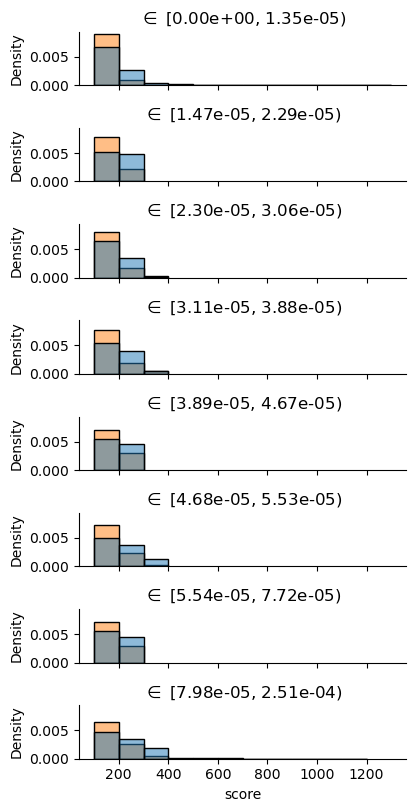

In [552]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a separate subplot for each "cut"
# g = sns.FacetGrid(diamonds, col="cut", col_wrap=1)
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(data, row="group", sharex=True, aspect=4, height=1)#, aspect=15, height=.5, palette=pal)

for (group, ax) in g.axes_dict.items():
    df_ = data.loc[data["group"] == group]
    sns.histplot(
        data=df_, x='score', hue='type',
        stat='density', common_bins=True, common_norm=False,
        ax=ax, alpha=0.5,
        binwidth=100
    )
    ax.set_title(f'$ \\in$ [{df_.score_cond.min():.2e}, {df_.score_cond.max():.2e})')
    # remove legend
    ax.get_legend().remove()

plt.show()

In [138]:
# TODO:
#       make a default scoring_config_dict for benchmark
#       speed up calculations for functions called twice? (e.g. limit_order_depth)
#       add: order flow imbalance

scoring_config_dict = {
    # TODO: order flow imbalance
    # TODO: returns, autocorrelation etc.
    # TODO:
    # "book_3d": {
    #     "fn": lambda m, b: eval.compute_3d_book_changes(m, b).values,
    #     "metric": 0,
    # },

    "spread": {
        "fn": lambda m, b: eval.spread(m, b).values,#.mean(),
        "discrete": True,
    },
    "orderbook_imbalance": {
        "fn": lambda m, b: eval.orderbook_imbalance(m, b).values,
    },

    #  TIMES (log scale)
    "log_inter_arrival_time": {
        # "fn": lambda m, b: eval.inter_arrival_time(m).values.astype(float),
        "fn": lambda m, b: np.log(eval.inter_arrival_time(m).replace({0: 1e-9}).values.astype(float)),
    },
    "log_time_to_cancel": {
        # "fn": lambda m, b: eval.time_to_cancel(m).values.astype(float),
        "fn": lambda m, b: np.log(
            eval.time_to_cancel(m)
            .dt.total_seconds()
            .replace({0: 1e-9})
            .values.astype(float)
        ),
    },

    # # VOLUMES:
    # "ask_volume_touch": {
    #     "fn": lambda m, b: eval.l1_volume(m, b).ask_vol.values,
    # },
    # "bid_volume_touch": {
    #     "fn": lambda m, b: eval.l1_volume(m, b).bid_vol.values,
    # },
    # "ask_volume": {
    #     "fn": lambda m, b: eval.total_volume(m, b, 10).ask_vol_10.values,
    # },
    # "bid_volume": {
    #     "fn": lambda m, b: eval.total_volume(m, b, 10).bid_vol_10.values,
    # },

    # # DEPTHS:
    # "limit_ask_order_depth": {
    #     "fn": lambda m, b: eval.limit_order_depth(m, b)[0].values,
    # },
    # "limit_bid_order_depth": {
    #     "fn": lambda m, b: eval.limit_order_depth(m, b)[1].values,
    # },
    # "ask_cancellation_depth": {
    #     "fn": lambda m, b: eval.cancellation_depth(m, b)[0].values,
    # },
    # "bid_cancellation_depth": {
    #     "fn": lambda m, b: eval.cancellation_depth(m, b)[1].values,
    # },

    # # LEVELS:
    # "limit_ask_order_levels": {
    #     "fn": lambda m, b: eval.limit_order_levels(m, b)[0].values,
    #     "discrete": True,
    # },
    # "limit_bid_order_levels": {
    #     "fn": lambda m, b: eval.limit_order_levels(m, b)[1].values,
    #     "discrete": True,
    # },
    # "ask_cancellation_levels": {
    #     "fn": lambda m, b: eval.cancel_order_levels(m, b)[0].values,
    #     "discrete": True,
    # },
    # "bid_cancellation_levels": {
    #     "fn": lambda m, b: eval.cancel_order_levels(m, b)[1].values,
    #     "discrete": True,
    # },

    # TODO:
    # "log_volatility_0.1s": {
    #     "fn": lambda m, b: [np.log(eval.volatility(m,b,'0.1s').replace({0:0.1}))] * len(m),
    #     "quantiles": np.arange(0.1, 1., 0.1),
    # },
}

scoring_config_dict_cond = {
    ######################## CONDITIONAL SCORING ########################
    "ask_volume | spread": {
        "eval": {
            "fn": lambda m, b: eval.l1_volume(m, b).ask_vol.values,
        },
        "cond": {
            "fn": lambda m, b: eval.spread(m, b).values,
            "discrete": True,
        }
    },
    "spread | time": {
        "eval": {
            "fn": lambda m, b: eval.spread(m, b).values,
        },
        "cond": {
            "fn": lambda m, b: eval.time_of_day(m).values,
            # group by hour of the day (start of sequence)
            "thresholds": np.linspace(0, 24*60*60, 24),
        }
    },
    "spread | volatility": {
        "eval": {
            "fn": lambda m, b: eval.spread(m, b).values,
            "discrete": True,
        },
        "cond": {
            "fn": lambda m, b: [eval.volatility(m,b,'0.1s')] * len(m),
        }
    }

    ########################################################
    # "time_to_first_fill": {
    #     "fn": lambda m, b: eval.time_to_first_fill(m).values.astype(float),
    # },


    # # touch volume, averaged over entire sequence:
    # "l1_ask_volume": {
    #     "fn": lambda m, b: eval.l1_volume(m, b).ask_vol.values.mean(),
    # },
    # "l1_bid_volume": {
    #     "fn": lambda m, b: eval.l1_volume(m, b).bid_vol.values.mean(),
    # },

    # # # touch volume, averaged over 10 order updates [only works if seq. len divisible by 10]:
    # # lambda m, b: eval.l1_volume(m, b).ask_vol.values.reshape(-1,10).mean(axis=1),
    # # lambda m, b: eval.l1_volume(m, b).bid_vol.values.reshape(-1,10).mean(axis=1),
    ########################################################
}

In [670]:
# TODO: sequence length and divergence!!
#       --> split all sequences into sub-sequences and
#           compute distributions per subsequence group

In [671]:
# TODO: 3d books --> divergence etc.
# TODO: -->  conditioning on cond sample?

#       output min, max, mean sequence lengths

In [ ]:
# TODO: add tqdm progress bar

In [141]:
scores, score_dfs, plot_fns = scoring.run_benchmark(
    loader,
    scoring_config_dict,
    # default_metric=metrics.l1_by_group
    # default_metric=metrics.wasserstein
    default_metric={
        'l1': metrics.l1_by_group,
        'wasserstein': metrics.wasserstein,
    }
)

In [139]:
scores_bench, score_dfs_bench, plot_fns_bench = scoring.run_benchmark(
    loader_bench,
    scoring_config_dict,
    # default_metric=metrics.l1_by_group
    # default_metric=metrics.wasserstein
    default_metric={
        'l1': metrics.l1_by_group,
        'wasserstein': metrics.wasserstein,
    }
)

In [5]:
import pickle
import gzip

def save_results(scores, scores_dfs, save_path, protocol=-1):
    # save tuple as pickle
    with gzip.open(save_path, 'wb') as f:
        tup = (scores, scores_dfs)
        pickle.dump(tup, f, protocol)

def load_results(save_path):
    with gzip.open(save_path, 'rb') as f:
        tup = pickle.load(f)
    return tup

In [142]:
save_results(scores, score_dfs, 'data_saved/GOOG/scores_s5_orig.pkl')

In [ ]:
save_results(scores_bench, score_dfs_bench, 'data_saved/GOOG/scores_bench.pkl')

In [84]:
scores_bench, score_dfs_bench = load_results('data_saved/GOOG/scores_bench.pkl')

In [11]:
scores, score_dfs = load_results(
    f'data_saved/scores_{stock}__20240930_222308.pkl'
)

In [ ]:
scores_bench, score_dfs_bench = load_results(
    f'data_saved/scores_{stock}_baseline_20240930_224204.pkl'
)

In [224]:
plotting.spider_plot(
    {
        "GenS5": scores,
        "Cont2010": scores_bench,
    },
    stock,
    "wasserstein",
    "Wasserstein Loss",
)

In [142]:
plotting.spider_plot(
                {
        "GenS5": scores,
        "Cont2010": scores_bench,
    },
                stock,
                'l1',
                title=f"{metric.capitalize()} Loss ({stock})",
                plot_cis=False,
                # save_path=f"{plot_dir}/spider_{stock}_{metric}.png"
            )

In [203]:
plotting.spider_plot(
    {
        "GenS5": scores,
        "Cont2010": scores_bench,
    },
    "wasserstein",
    "Wasserstein Loss",
)

In [790]:
# 45m GOOG

In [791]:
scores_cond, score_dfs_cond, plot_fns_cond = scoring.run_benchmark(
    loader,
    scoring_config_dict_cond,
    # default_metric=metrics.l1_by_group
    # default_metric=metrics.wasserstein
    default_metric={
        'l1': metrics.l1_by_group,
        'wasserstein': metrics.wasserstein,
    }
)

weigth: 0.09986895798351121
weigth: 0.10010718704700808
weigth: 0.09993083982638455
weigth: 0.10008249843612078


weigth: 0.09988402765509177
weigth: 0.1000853841179128
weigth: 0.09989076091260649
weigth: 0.10012450113776021
weigth: 0.1000097151286998
weigth: 0.1000161277549043


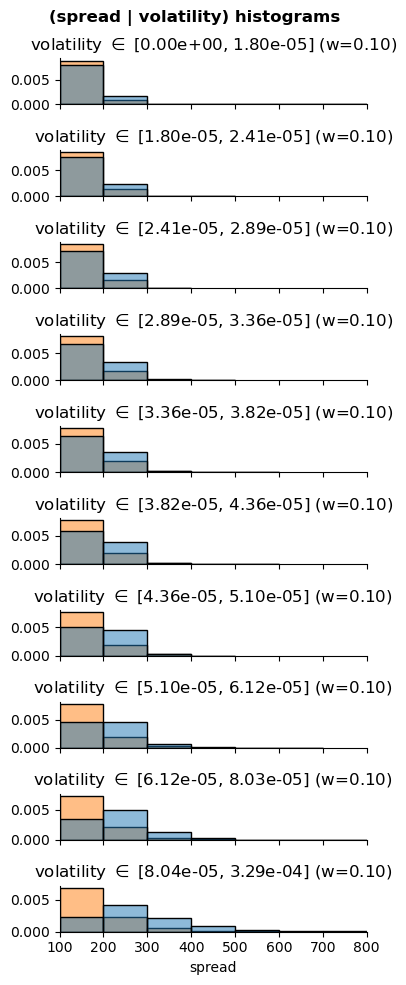

In [776]:
plot_fns_cond['spread | volatility']('spread', 'volatility', None, 100)

weigth: 0.29892841809809845
weigth: 0.17899563524597392
weigth: 0.13164736840248978
weigth: 0.10717069481125557
weigth: 0.11844569483530291
weigth: 0.11618460283559919
weigth: 0.04862758577128022


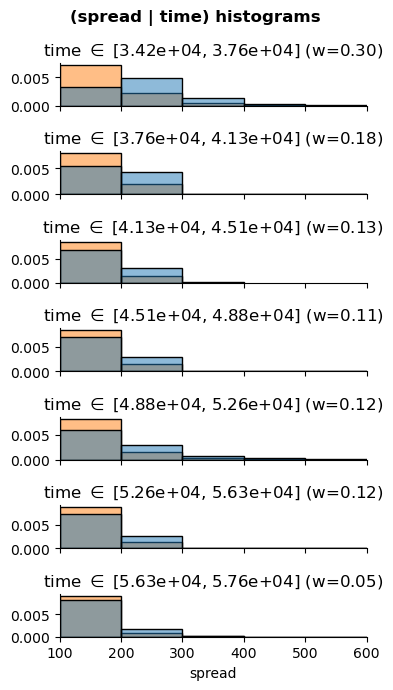

In [779]:
plot_fns_cond['spread | time']('spread', 'time', None, 100)

weigth: 0.6752168349393222
weigth: 0.2727459859364695
weigth: 0.03883550555702155


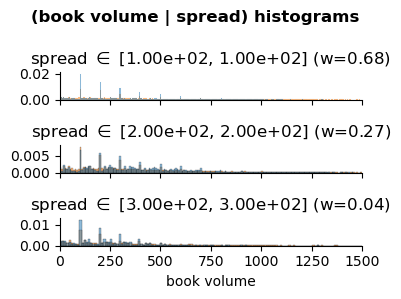

In [787]:
plot_fns_cond['ask_volume | spread']('book volume', 'spread', 'fd', None)

In [739]:
scores#['ask_volume_X_spread']['wasserstein']

{'spread': {'l1': (0.24520058869279107,
   array([0.24392365, 0.24612149]),
   array([0.24520059, 0.24527414, 0.24595266, 0.2454195 , 0.24604783,
          0.24554847, 0.24498273, 0.24531655, 0.24553127, 0.24454779,
          0.24473043, 0.2455489 , 0.24476441, 0.24507602, 0.24489134,
          0.245181  , 0.24524808, 0.24560296, 0.24515715, 0.24557754,
          0.24476681, 0.2448392 , 0.24461109, 0.24399265, 0.24532629,
          0.24468495, 0.24540351, 0.24549628, 0.24434375, 0.24528211,
          0.24486181, 0.24552107, 0.24483621, 0.24478088, 0.24559224,
          0.24526506, 0.24541004, 0.24460424, 0.2452917 , 0.24528721,
          0.24593951, 0.24572424, 0.24592205, 0.24521996, 0.24499881,
          0.24504552, 0.24510561, 0.24581119, 0.24485528, 0.24533714,
          0.24524501, 0.24555805, 0.24518803, 0.24554446, 0.24558227,
          0.24465326, 0.2445823 , 0.24590779, 0.2456361 , 0.24567659,
          0.24474967, 0.24433484, 0.24525299, 0.24409795, 0.24536564,
          0.24

In [740]:
scoring.summary_stats(scores, bootstrap=False)

{'l1': (0.13908787948212303, 0.12758355380736258, array(0.13720407)),
 'wasserstein': (0.1106735602701929, 0.07536054995244845, array(0.07999531))}

In [14]:
summary_stats = scoring.summary_stats(scores, bootstrap=True)
summary_stats

{'l1': ((0.13923482533275094, array([0.13879532, 0.1399331 ])),
  (0.12758355380736258, array([0.12582824, 0.12983594])),
  (array(0.13720407), array([0.13647473, 0.13809695]))),
 'wasserstein': ((0.11454407552832652, array([0.11361937, 0.11554076])),
  (0.0773848204131511, array([0.07596588, 0.07911159])),
  (array(0.08205152), array([0.08074019, 0.08351249])))}

In [15]:
summary_stats_bench = scoring.summary_stats(scores_bench, bootstrap=True)
summary_stats_bench

{'l1': ((0.4750381091560282, array([0.47455601, 0.47558652])),
  (0.4155230519083538, array([0.41463319, 0.416626  ])),
  (array(0.46230215), array([0.46169096, 0.4629928 ]))),
 'wasserstein': ((0.6149371976837739, array([0.61387055, 0.61603603])),
  (0.4124053603191611, array([0.40981696, 0.41547152])),
  (array(0.47947519), array([0.47768122, 0.4813172 ])))}

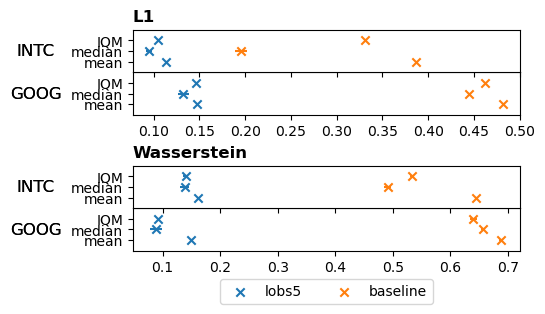

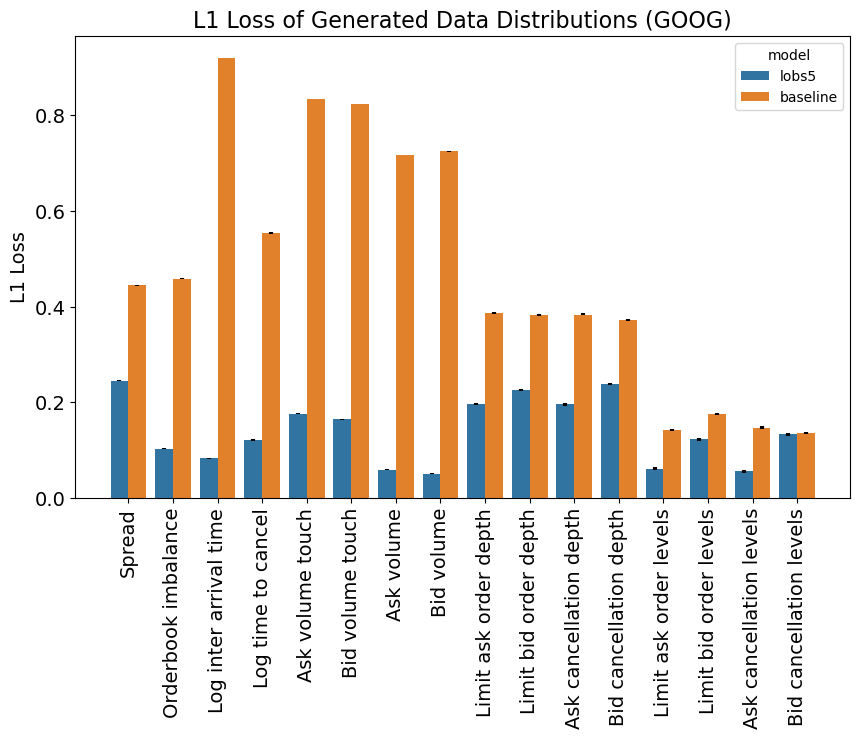

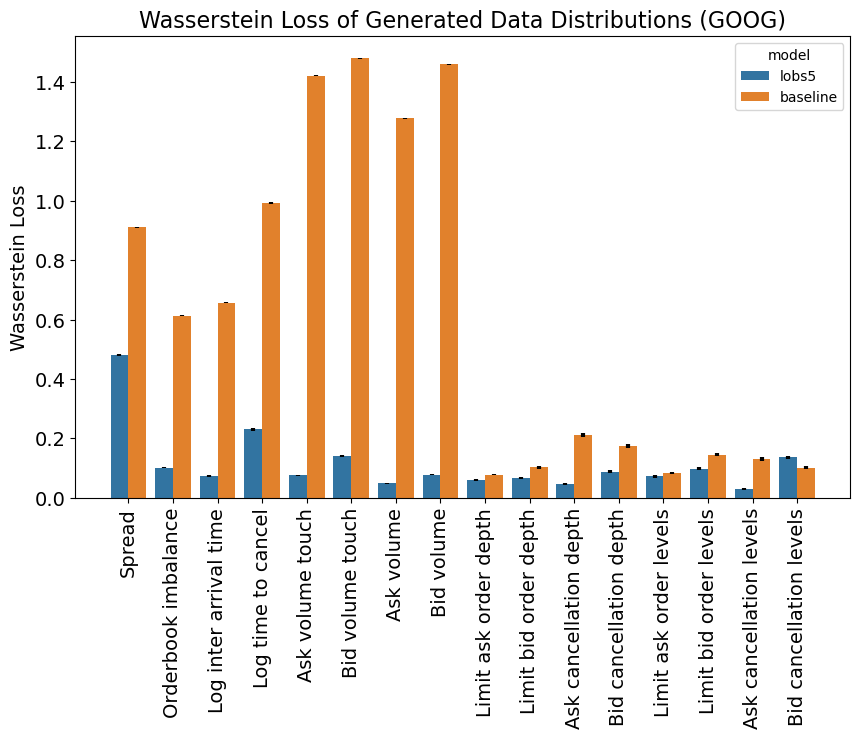

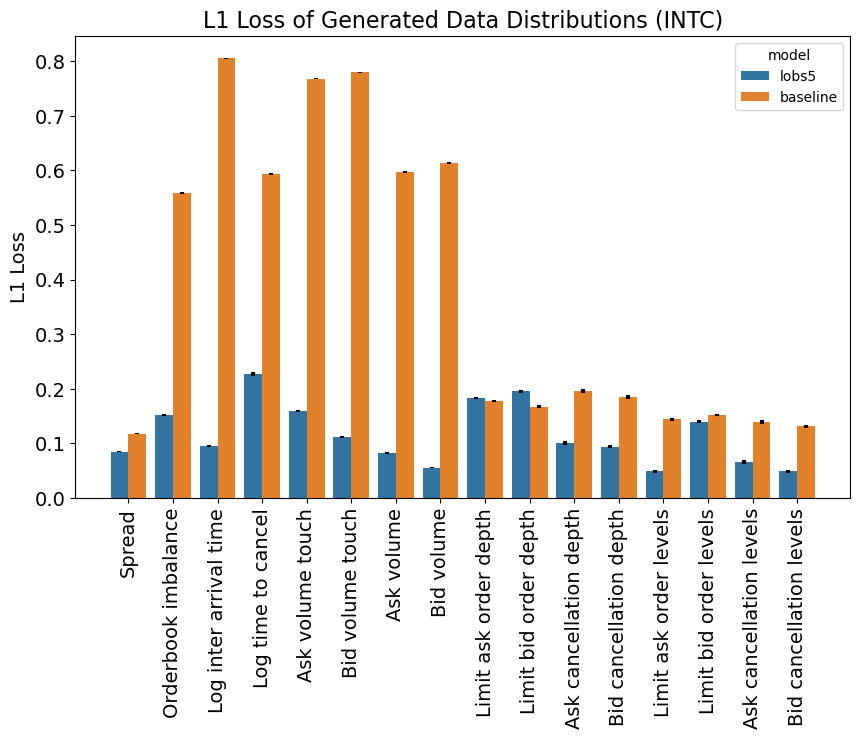

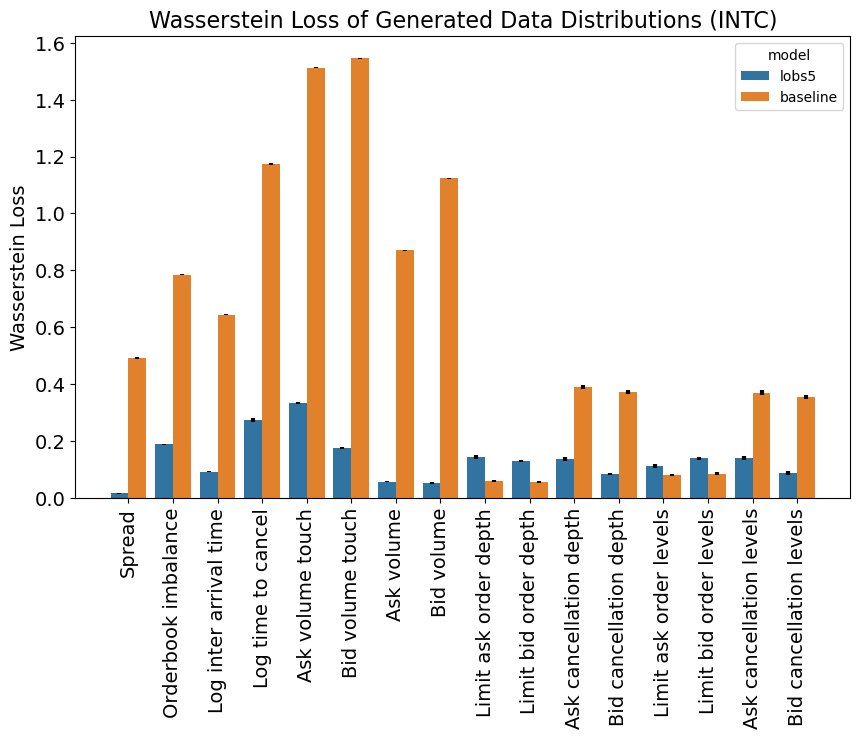

In [161]:
from run_bench import run_plotting

run_plotting("data_saved", "images")

In [68]:
{"m1": 1} | {"m2": 2}

{'m1': 1, 'm2': 2}

In [73]:
scores_cond, scores_cond_dfs = load_results('data_saved/scores_cond_GOOG_lobs5_20240930_222308.pkl')

In [74]:
scores_cond

{'ask_volume | spread': {'l1': (0.10661426070225365,
   array([0.10509498, 0.10781055]),
   array([0.10661426, 0.10721522, 0.10697266, 0.10753848, 0.10666156,
          0.10684305, 0.10587426, 0.10648688, 0.10651496, 0.10689375,
          0.10580765, 0.10714422, 0.10720083, 0.1069638 , 0.10637012,
          0.10661714, 0.10686133, 0.1064324 , 0.10734767, 0.10603629,
          0.10600619, 0.10740904, 0.10634189, 0.10634745, 0.10689369,
          0.10769549, 0.10757262, 0.10684495, 0.10585506, 0.1065628 ,
          0.10615167, 0.10641888, 0.10693968, 0.10655154, 0.10590787,
          0.10623317, 0.106727  , 0.10675857, 0.10627772, 0.10735341,
          0.10784946, 0.10673313, 0.10697745, 0.10607273, 0.10677593,
          0.10581391, 0.10616308, 0.10650981, 0.10605507, 0.10701334,
          0.10679783, 0.1053595 , 0.10666015, 0.10601789, 0.10737609,
          0.10676403, 0.10746713, 0.10641431, 0.10593347, 0.10639467,
          0.10696958, 0.10672845, 0.10679988, 0.1067675 , 0.10518742,
 

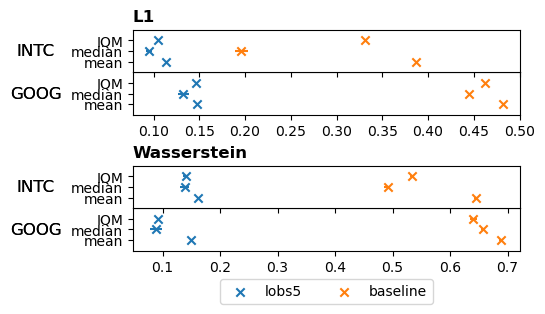

In [76]:
from run_bench import run_plotting

run_plotting("data_saved", "images")

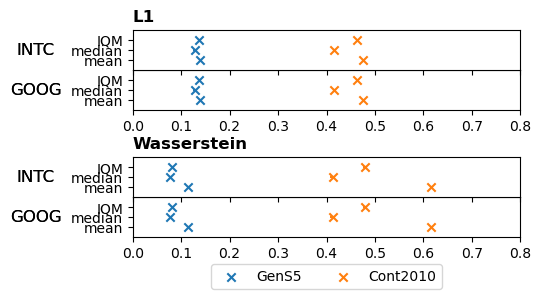

In [56]:
# TODO: circles for INTC on same plot
# TODO: padding for labels
# NOTE: errorbars are there but very small

plotting.summary_plot(
    {
        "GOOG": {
            "GenS5": summary_stats,
            "Cont2010": summary_stats_bench,
        },
        "INTC": {
            "GenS5": summary_stats,
            "Cont2010": summary_stats_bench,
        },
    },
    [(0, 0.8), (0, 0.8)],
)

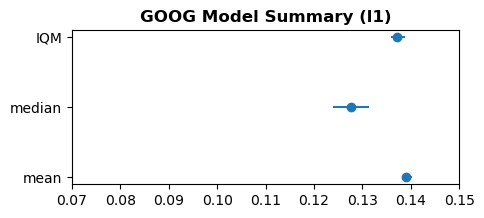

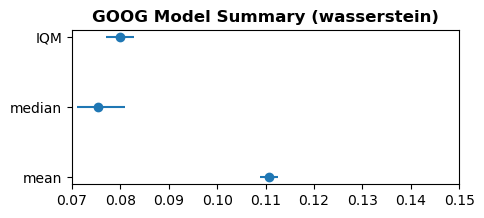

In [792]:
for loss_metric, xrange in zip(summary_stats.keys(), [(0.07, 0.15), (0.07, 0.15)]):

    scatter_vals = summary_stats[loss_metric]
    scatter_x = [val[0] for val in scatter_vals]
    cis = np.array([val[1] for val in scatter_vals])

    plt.figure(figsize=(5,2))
    plt.scatter(scatter_x, ['mean', 'median', 'IQM'])
    # add errorbars
    plt.errorbar(
        x=cis.mean(axis=1),
        y=['mean', 'median', 'IQM'],
        xerr=np.diff(cis, axis=1).T[0],
        fmt='none'
    )
    # set xrange
    plt.xlim(*xrange)
    plt.title(f"{stock} Model Summary ({loss_metric})", fontweight='bold')
    plt.savefig(f'images/summary_stats_{loss_metric}_{stock}.png', dpi=300, bbox_inches='tight')

In [78]:
test = {"GOOG": {"GenS5": np.array([1,2])}}
pd.DataFrame(test)

,GOOG
GenS5,"[1, 2]"


In [98]:
data = _scores_to_df({
        "GOOG": {
            "GenS5": scores,
            "Cont2010": scores_bench,
        },
        "INTC": {
            "GenS5": scores,
            "Cont2010": scores_bench,
        },
    })
data

,stock,model,metric,score,mean,ci_low,ci_high
0,GOOG,GenS5,l1,spread,0.245201,0.243817,0.246478
1,GOOG,GenS5,wasserstein,spread,0.481555,0.478992,0.484002
2,GOOG,GenS5,l1,orderbook_imbalance,0.102392,0.101355,0.103660
3,GOOG,GenS5,wasserstein,orderbook_imbalance,0.101552,0.100086,0.103056
4,GOOG,GenS5,l1,log_inter_arrival_time,0.082978,0.082131,0.084483
...,...,...,...,...,...,...,...
123,INTC,Cont2010,wasserstein,limit_bid_order_levels,0.145653,0.140278,0.150699
124,INTC,Cont2010,l1,ask_cancellation_levels,0.146877,0.143389,0.151271
125,INTC,Cont2010,wasserstein,ask_cancellation_levels,0.131921,0.125125,0.137395
126,INTC,Cont2010,l1,bid_cancellation_levels,0.136285,0.132675,0.138775


In [114]:
data.loc[(data.metric==metric) & (data.stock==stock)]

,stock,model,metric,score,mean,ci_low,ci_high
0,GOOG,GenS5,l1,spread,0.245201,0.243817,0.246478
2,GOOG,GenS5,l1,orderbook_imbalance,0.102392,0.101355,0.103660
4,GOOG,GenS5,l1,log_inter_arrival_time,0.082978,0.082131,0.084483
6,GOOG,GenS5,l1,log_time_to_cancel,0.121365,0.119237,0.123826
8,GOOG,GenS5,l1,ask_volume_touch,0.176292,0.175128,0.177833
10,GOOG,GenS5,l1,bid_volume_touch,0.164022,0.163033,0.165137
12,GOOG,GenS5,l1,ask_volume,0.058202,0.057353,0.059863
14,GOOG,GenS5,l1,bid_volume,0.049783,0.049000,0.051599
16,GOOG,GenS5,l1,limit_ask_order_depth,0.196560,0.194442,0.198873
18,GOOG,GenS5,l1,limit_bid_order_depth,0.225327,0.223540,0.227972


In [122]:
err = (
    data.loc[
        (data.metric==metric) & (data.stock==stock),
        ["ci_low", "ci_high"]
    ].diff(axis=1).iloc[:,1] / 2
)
print(len(err))
err

32


0     0.001331
2     0.001152
4     0.001176
6     0.002294
8     0.001353
10    0.001052
12    0.001255
14    0.001299
16    0.002215
18    0.002216
20    0.002508
22    0.002336
24    0.003414
26    0.002767
28    0.002847
30    0.002891
32    0.000981
34    0.001060
36    0.000525
38    0.002377
40    0.000638
42    0.000677
44    0.000806
46    0.000911
48    0.001659
50    0.002258
52    0.002041
54    0.001712
56    0.002079
58    0.002380
60    0.003941
62    0.003050
Name: ci_high, dtype: float64

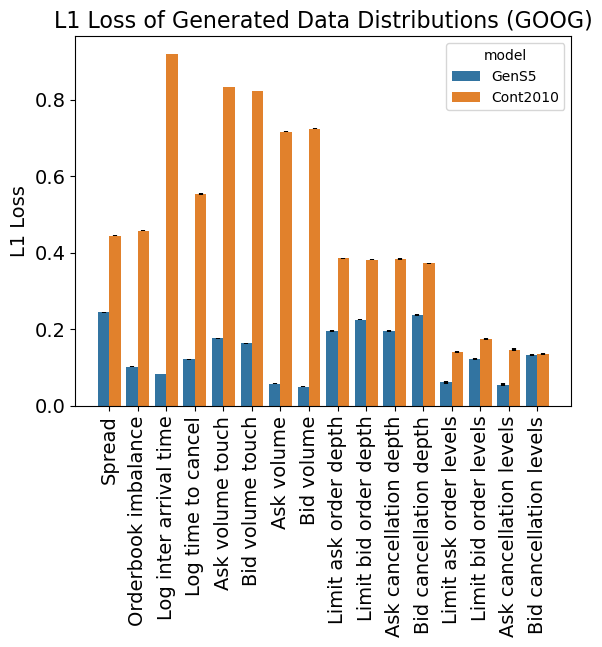

In [138]:
metric = "l1"

data_ = data.loc[(data.metric==metric) & (data.stock==stock)].copy()
y_err = data_.loc[:, ["ci_low", "ci_high"]].diff(axis=1).iloc[:,1] / 2
y_coords = data_.loc[:, ["ci_low", "ci_high"]].mean(axis=1)
n_models = len(data_.model.unique())

data_.score = data_.score.str.replace('_', ' ').str.capitalize()

ax = sns.barplot(
    data=data_,
    x="score",
    y="mean",
    hue="model",
)

# get x-coords of bars only (without the legend elements)
x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches][:-n_models]
ax.errorbar(
    x=x_coords,
    y=y_coords,
    yerr=y_err,
    fmt="none",
    c="k",
    elinewidth=3
)

_ = plt.xticks(rotation=90)

plt.title(
    f'{metric.capitalize()} Loss of Generated Data Distributions ({stock})',
    fontsize=16
)
plt.ylabel(f'{metric.capitalize()} Loss', fontsize=14)
plt.xlabel('')
# Customize tick labels
ax.tick_params(axis='x', labelsize=14)  # X tick labels font size
ax.tick_params(axis='y', labelsize=14)  # Y tick labels font size

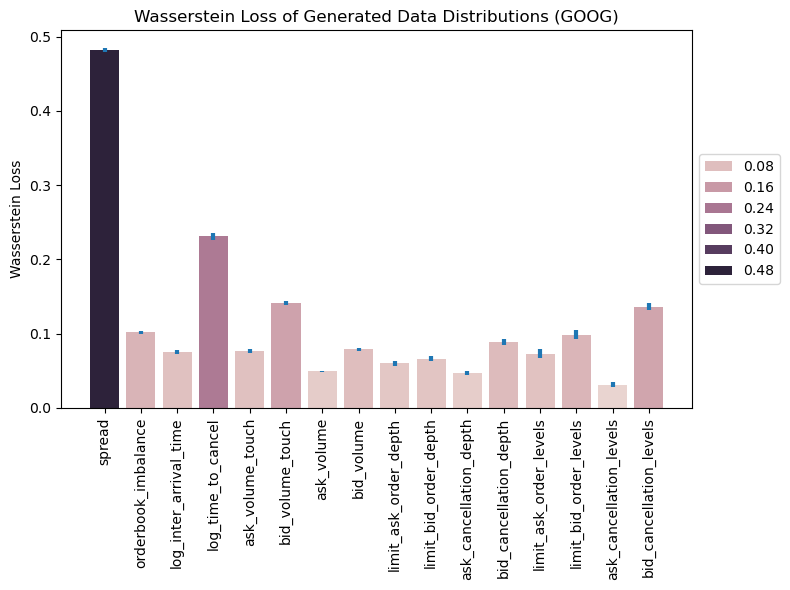

In [802]:
# Wasserstein Loss

import matplotlib.pyplot as plt
import seaborn as sns

labels = list(scores.keys())
# pal = sns.color_palette("rocket", len(scores))
losses = np.array([s['wasserstein'][0]for s in scores.values()])
cis = np.array([s['wasserstein'][1]for s in scores.values()]).T

plt.figure(figsize=(8,6))
b = sns.barplot(
    x=labels,
    y=losses,
    hue=losses,
    legend='brief'
    # palette=np.array(pal[::-1])[rank]
)
plt.errorbar( # ([0.01]*len(labels), [0.03]*len(labels))
    x=labels, y=cis.mean(axis=0), yerr=np.diff(cis, axis=0)/2,
    fmt='none', elinewidth=3)
_ = plt.xticks(rotation=90)

plt.title(f'Wasserstein Loss of Generated Data Distributions ({stock})')
plt.ylabel('Wasserstein Loss')

plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# save fig as png
plt.savefig(f'images/bar_plot_comparison_wasserstein_{stock}.png')

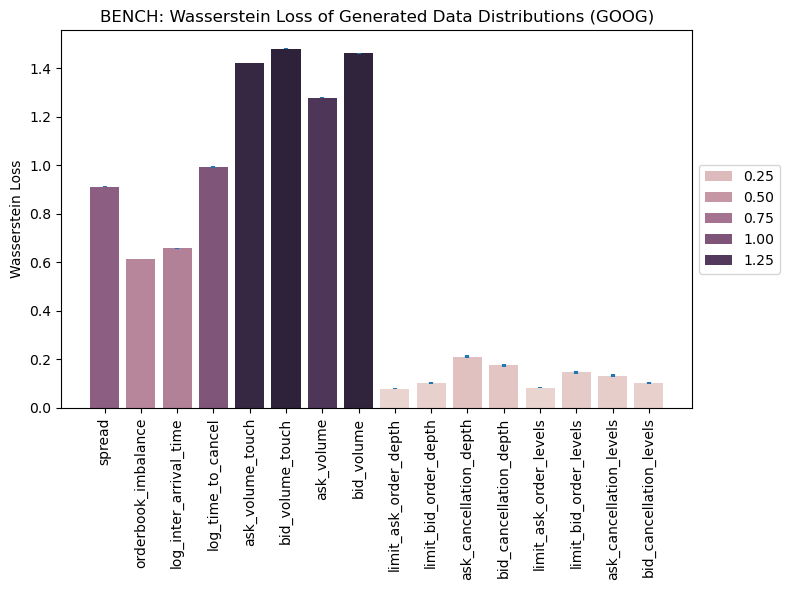

In [17]:
# Wasserstein Loss BENCHMARK

import matplotlib.pyplot as plt
import seaborn as sns

labels = list(scores_bench.keys())
# pal = sns.color_palette("rocket", len(scores))
losses = np.array([s['wasserstein'][0]for s in scores_bench.values()])
cis = np.array([s['wasserstein'][1]for s in scores_bench.values()]).T

plt.figure(figsize=(8,6))
b = sns.barplot(
    x=labels,
    y=losses,
    hue=losses,
    legend='brief'
    # palette=np.array(pal[::-1])[rank]
)
plt.errorbar( # ([0.01]*len(labels), [0.03]*len(labels))
    x=labels, y=cis.mean(axis=0), yerr=np.diff(cis, axis=0)/2,
    fmt='none', elinewidth=3)
_ = plt.xticks(rotation=90)

plt.title(f'BENCH: Wasserstein Loss of Generated Data Distributions ({stock})')
plt.ylabel('Wasserstein Loss')

plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# save fig as png
# plt.savefig(f'images/bar_plot_comparison_wasserstein_{stock}.png')

In [803]:
import plotly.graph_objects as go

labels = list(scores.keys())
# pal = sns.color_palette("rocket", len(scores))
losses = np.array([s['wasserstein'][0]for s in scores.values()])
cis = np.array([s['wasserstein'][1]for s in scores.values()]).T

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=-losses,
    theta=labels,
    mode='lines',
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.2)',  # Set opacity to 0.5
    name='CI upper',
    line=dict(color='rgba(31, 119, 180, 1)'),
))
fig.add_trace(go.Scatterpolar(
    r=-cis[0],
    theta=labels,
    mode='lines',  # Add this line to remove markers
    name='CI lower',
    line=dict(color='rgba(31, 119, 180, 0.2)', width=0),
    # fill='tonext',
))
fig.add_trace(go.Scatterpolar(
    r=-cis[1],
    theta=labels,
    mode='lines',  # Add this line to remove markers
    fill='tonext',
    fillcolor='rgba(31, 119, 180, 0.5)',
    name='CI upper',
    line=dict(color='rgb(31, 119, 180)', width=0),
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      # range=[0.5, 1]
    )),
  showlegend=False,
  title=f'Wasserstein Distances ({stock})',
  margin=dict(l=20, r=20, t=40, b=40),
)

fig.write_image(f"images/wasserstein_comparison_{stock}.png")
fig.show()


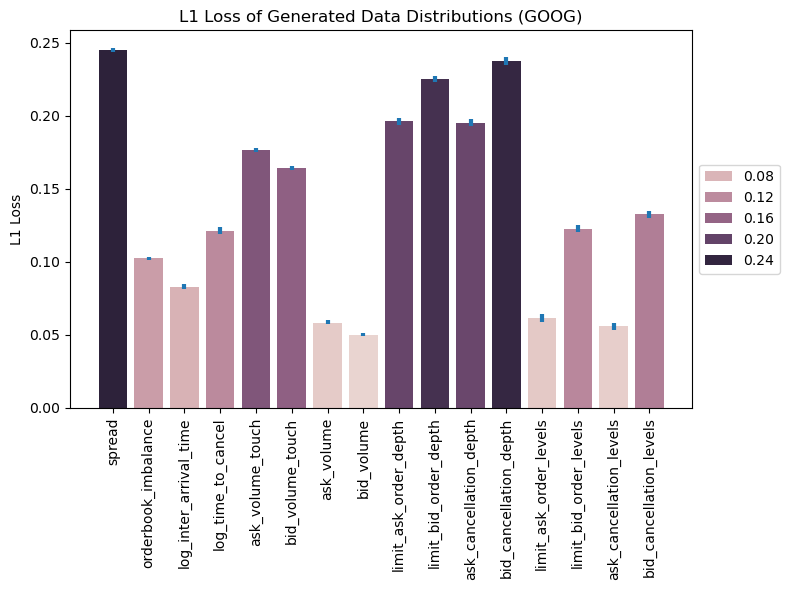

In [804]:
# L1 Loss

import matplotlib.pyplot as plt
import seaborn as sns

labels = list(scores.keys())
# pal = sns.color_palette("rocket", len(scores))
losses = np.array([s['l1'][0]for s in scores.values()])
cis = np.array([s['l1'][1]for s in scores.values()]).T

plt.figure(figsize=(8,6))
b = sns.barplot(
    x=labels,
    y=losses,
    hue=losses,
    legend='brief'
    # palette=np.array(pal[::-1])[rank]
)
plt.errorbar( # ([0.01]*len(labels), [0.03]*len(labels))
    x=labels, y=cis.mean(axis=0), yerr=np.diff(cis, axis=0)/2,
    fmt='none', elinewidth=3)
_ = plt.xticks(rotation=90)

plt.title(f'L1 Loss of Generated Data Distributions ({stock})')
plt.ylabel('L1 Loss')

plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# save fig as png
plt.savefig(f'images/bar_plot_comparison_l1_{stock}.png')

In [805]:
import plotly.graph_objects as go

fig = go.Figure()

labels = list(scores.keys())
# pal = sns.color_palette("rocket", len(scores))
losses = np.array([s['l1'][0]for s in scores.values()])
cis = np.array([s['l1'][1]for s in scores.values()]).T

fig.add_trace(go.Scatterpolar(
    r=1-losses,
    theta=labels,
    mode='lines',
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.2)',  # Set opacity to 0.5
    name='CI upper',
    line=dict(color='rgba(31, 119, 180, 1)'),
))
fig.add_trace(go.Scatterpolar(
    r=1-cis[0],
    theta=labels,
    mode='lines',  # Add this line to remove markers
    name='CI lower',
    line=dict(color='rgba(31, 119, 180, 0.2)', width=0),
    # fill='tonext',
))
fig.add_trace(go.Scatterpolar(
    r=1-cis[1],
    theta=labels,
    mode='lines',  # Add this line to remove markers
    fill='tonext',
    fillcolor='rgba(31, 119, 180, 0.5)',
    name='CI upper',
    line=dict(color='rgb(31, 119, 180)', width=0),
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0.5, 1]
    )),
  showlegend=False,
  title=f'L1 Scores ({stock})',
  margin=dict(l=20, r=20, t=40, b=40),
)

fig.write_image(f"images/l1_comparison_{stock}.png")
fig.show()


In [747]:
plot_fns

{'spread': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'orderbook_imbalance': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'log_inter_arrival_time': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'log_time_to_cancel': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'ask_volume_touch': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'bid_volume_touch': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'ask_volume': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'bid_volume': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'limit_ask_order_depth': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'limit_bid_order_depth': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'ask_cancellation_depth': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'bid_cancellation_depth': <function scoring.score_data.<locals>.<lambda>(title, ax)>,
 'limit_ask_order

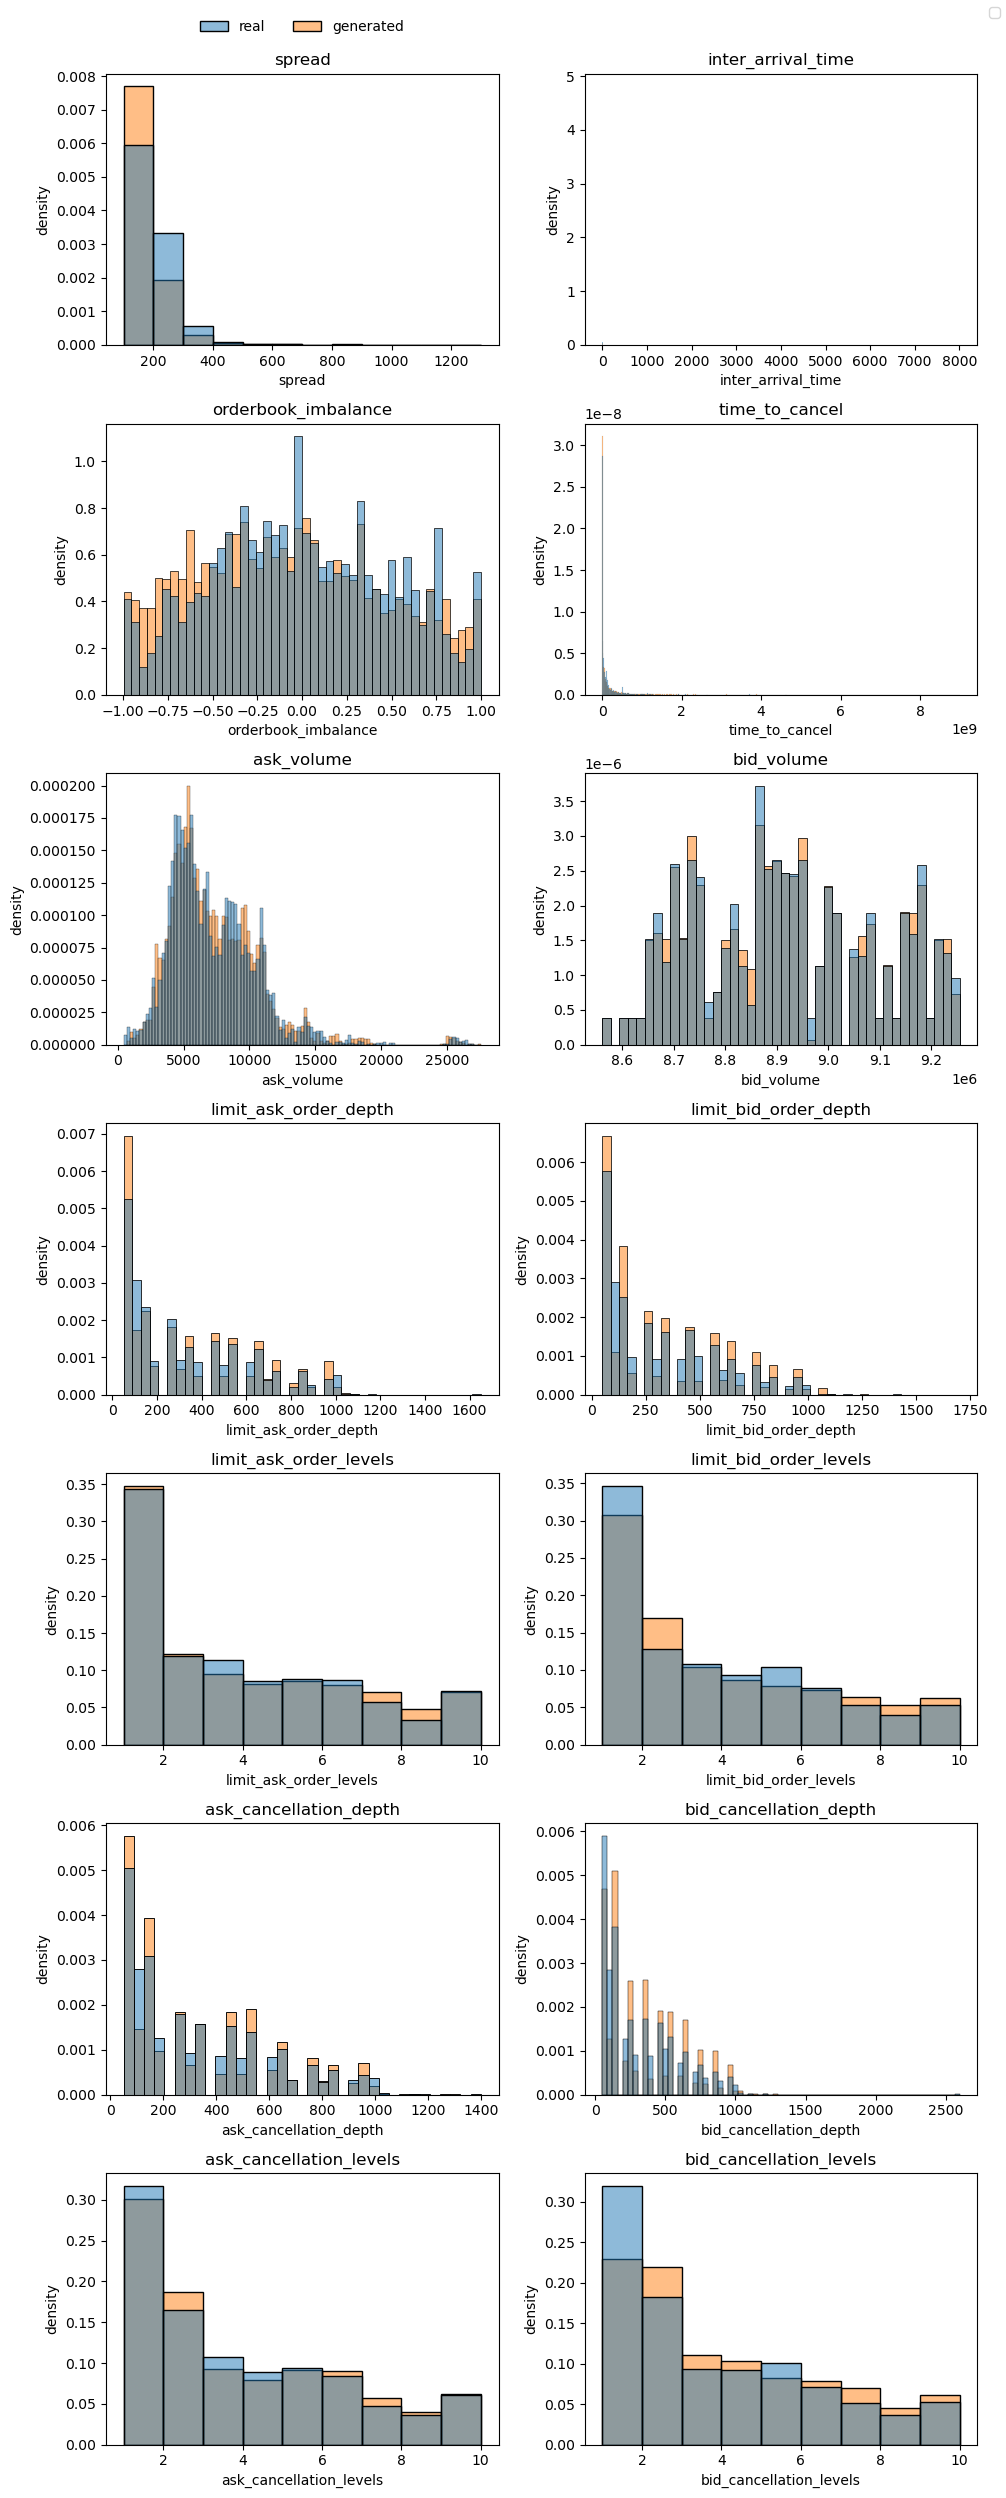

In [132]:

# Plot all histograms in single subplot
plotting.hist_subplots(plot_fns, (10, 25))

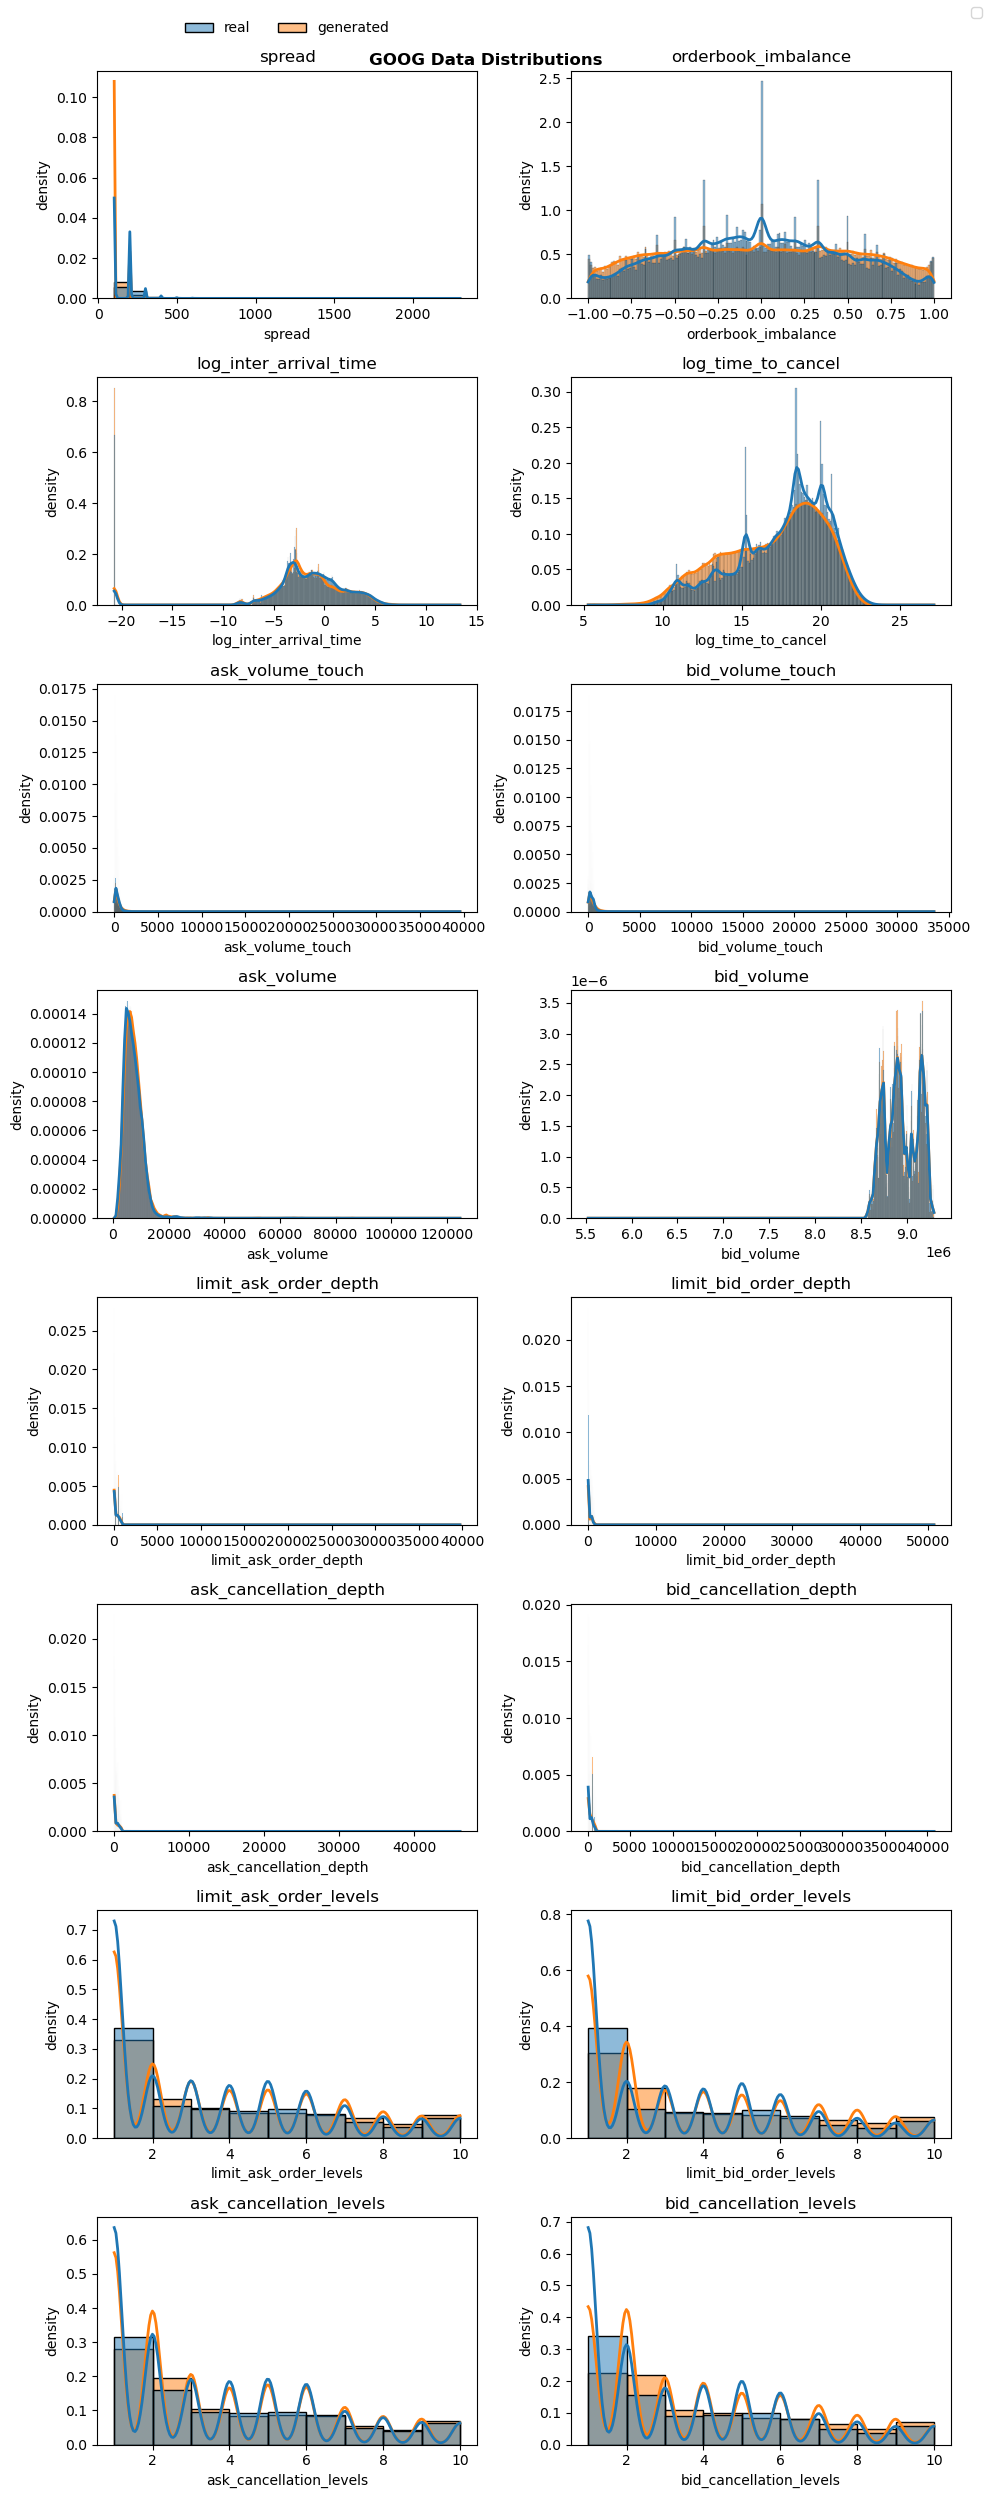

In [748]:
# Plot all histograms in single subplot
plotting.hist_subplots(plot_fns, (10, 25))
plt.suptitle(f'{stock} Data Distributions', fontweight='bold')
plt.savefig(f'images/hist_subplots_{stock}.png', dpi=300, bbox_inches='tight')

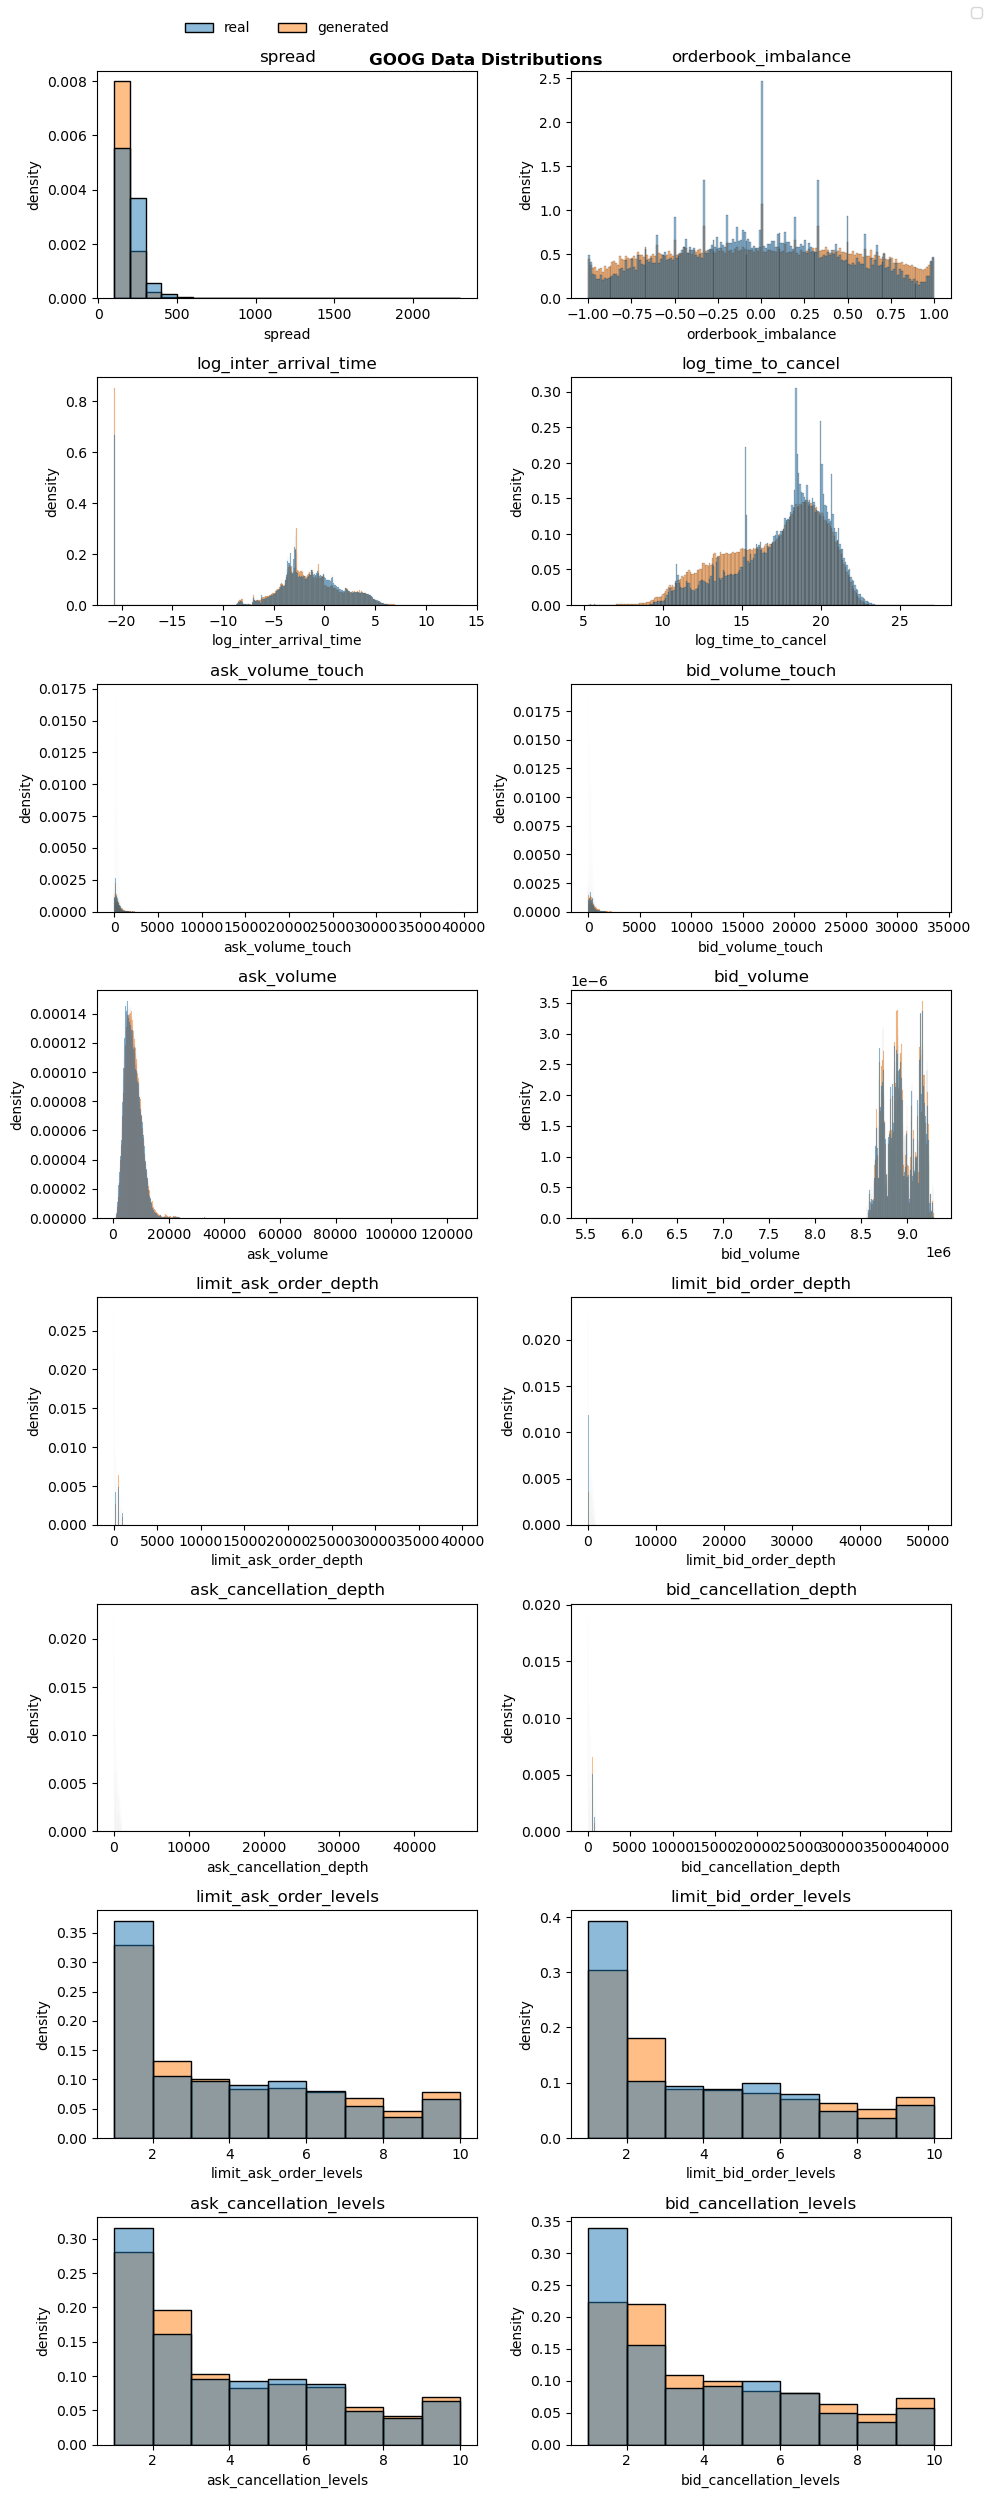

In [754]:
# Plot all histograms in single subplot
plotting.hist_subplots(plot_fns, (10, 25))
plt.suptitle(f'{stock} Data Distributions', fontweight='bold')
plt.savefig(f'images/hist_subplots_{stock}_nokde.png', dpi=300, bbox_inches='tight')

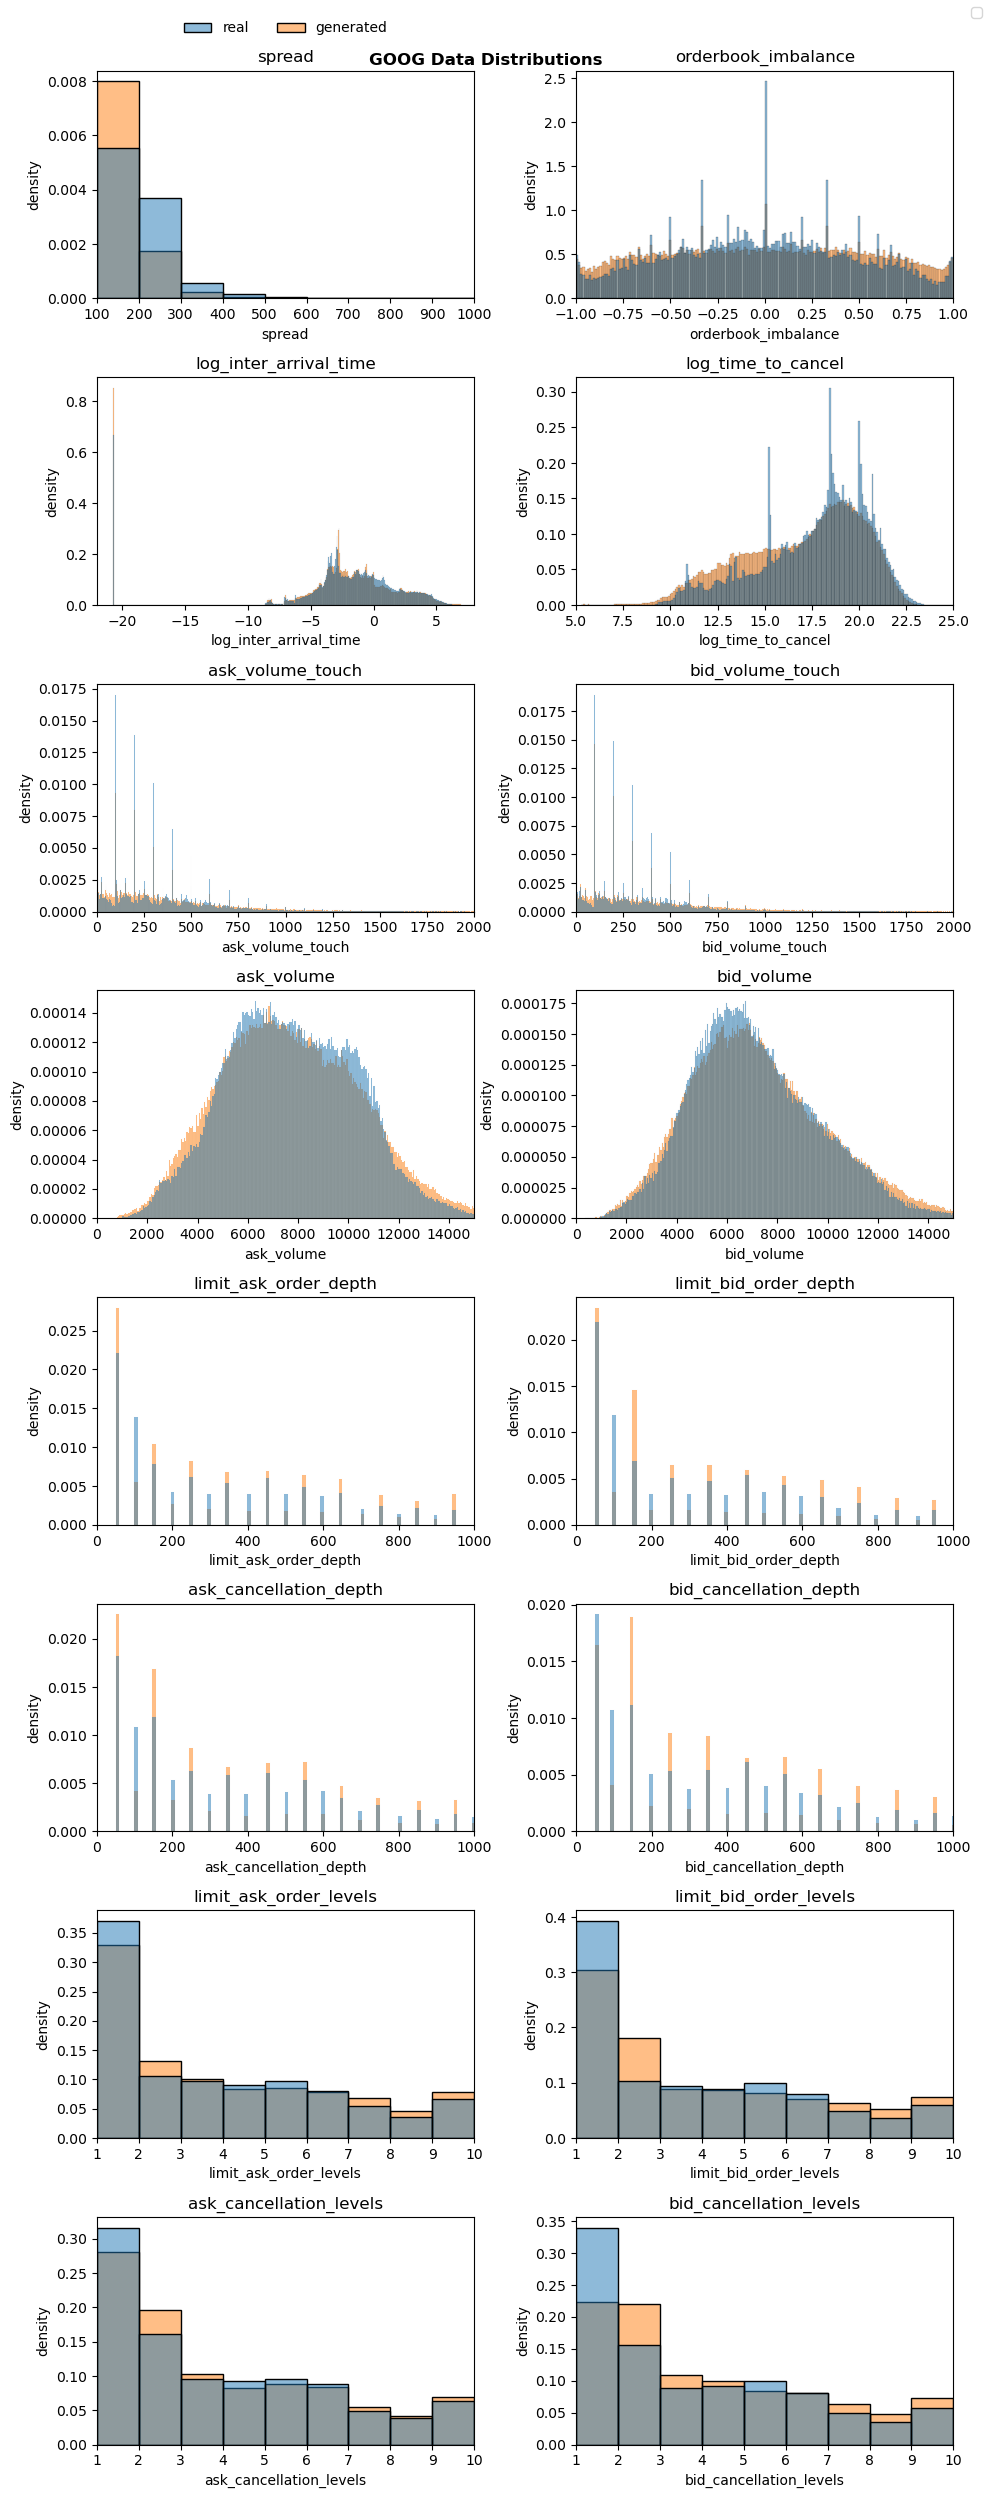

In [798]:
# Plot all histograms in single subplot
plotting.hist_subplots(plot_fns, (10, 25))
plt.suptitle(f'{stock} Data Distributions', fontweight='bold')
plt.savefig(f'images/hist_subplots_{stock}_test.png', dpi=300, bbox_inches='tight')

In [209]:
score_dfs.keys()

dict_keys(['spread', 'orderbook_imbalance', 'log_inter_arrival_time', 'log_time_to_cancel', 'ask_volume_touch', 'bid_volume_touch', 'ask_volume', 'bid_volume', 'limit_ask_order_depth', 'limit_bid_order_depth', 'ask_cancellation_depth', 'bid_cancellation_depth', 'limit_ask_order_levels', 'limit_bid_order_levels', 'ask_cancellation_levels', 'bid_cancellation_levels'])

In [210]:
score_dfs["orderbook_imbalance"]

,score,group,type
0,-0.946229,5,real
1,-0.946229,5,real
2,-0.946229,5,real
3,-0.946229,5,real
4,-0.946229,5,real
...,...,...,...
3118842,0.340602,120,generated
3118843,0.340602,120,generated
3118844,0.340602,120,generated
3118845,0.340602,120,generated


In [233]:
for score_name, score_df in score_dfs.items():
    print(score_df.head())

   score  group  type
0    700      7  real
1    700      7  real
2    700      7  real
3    700      7  real
4    700      7  real
      score  group  type
0 -0.946229      5  real
1 -0.946229      5  real
2 -0.946229      5  real
3 -0.946229      5  real
4 -0.946229      5  real
      score  group  type
0  3.040489    436  real
1  4.541166    464  real
2  2.814030    432  real
3  3.387930    443  real
4  3.266173    440  real
      score  group  type
0 -1.023755    166  real
1 -1.269853    164  real
2 -3.112728    142  real
3 -7.691898     90  real
4 -7.643910     90  real
   score  group  type
0   4090    826  real
1   4090    826  real
2   4090    826  real
3   4090    826  real
4   4090    826  real
   score  group  type
0    113     23  real
1    113     23  real
2    113     23  real
3    113     23  real
4    113     23  real
   score  group  type
0   4994     89  real
1   4994     89  real
2   4994     89  real
3   4994     89  real
4   4994     89  real
   score  group  type


In [270]:
pd.Series(score_dfs["spread"].score.unique()).sort_values().diff().min()

100.0

In [294]:
def _get_plot_fn(score_df):
    unique_scores = score_df.score.unique()
    if unique_scores.shape[0] < 80:
        discrete = True
        min_diff = pd.Series(
            score_df.score.unique()
        ).sort_values().diff().min()
        binwidth = min_diff if min_diff > 0 else 1
    else:
        discrete = False
        binwidth = None

    def _score_hist_plot(name, ax):
        # mean, std = score_df.score.mean(), score_df.score.std()
        # xmin = max(mean - 3*std, score_df.score.min())
        # xmax = min(mean + 3*std, score_df.score.max())
        # get outliers based on quantiles
        q1, q3 = score_df.score.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - 2 * iqr
        upper_bound = q3 + 2 * iqr
        xmin = max(score_df.score.min(), lower_bound)
        xmax = min(score_df.score.max(), upper_bound)
        sns.histplot(
            score_df,
            x="score",
            hue="type",
            stat="density",
            common_bins=True,
            ax=ax,
            # discrete=discrete,
            binwidth=binwidth,
        )
        ax.set_title(name.capitalize().replace("_", " "), fontsize=18)
        ax.set_xlabel("")
        ax.set_xlim(xmin, xmax)
        ax.set_ylabel("Density", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=14)
    return _score_hist_plot

plot_fns = {
    score_name: _get_plot_fn(score_df)
        for score_name, score_df in score_dfs.items()
}


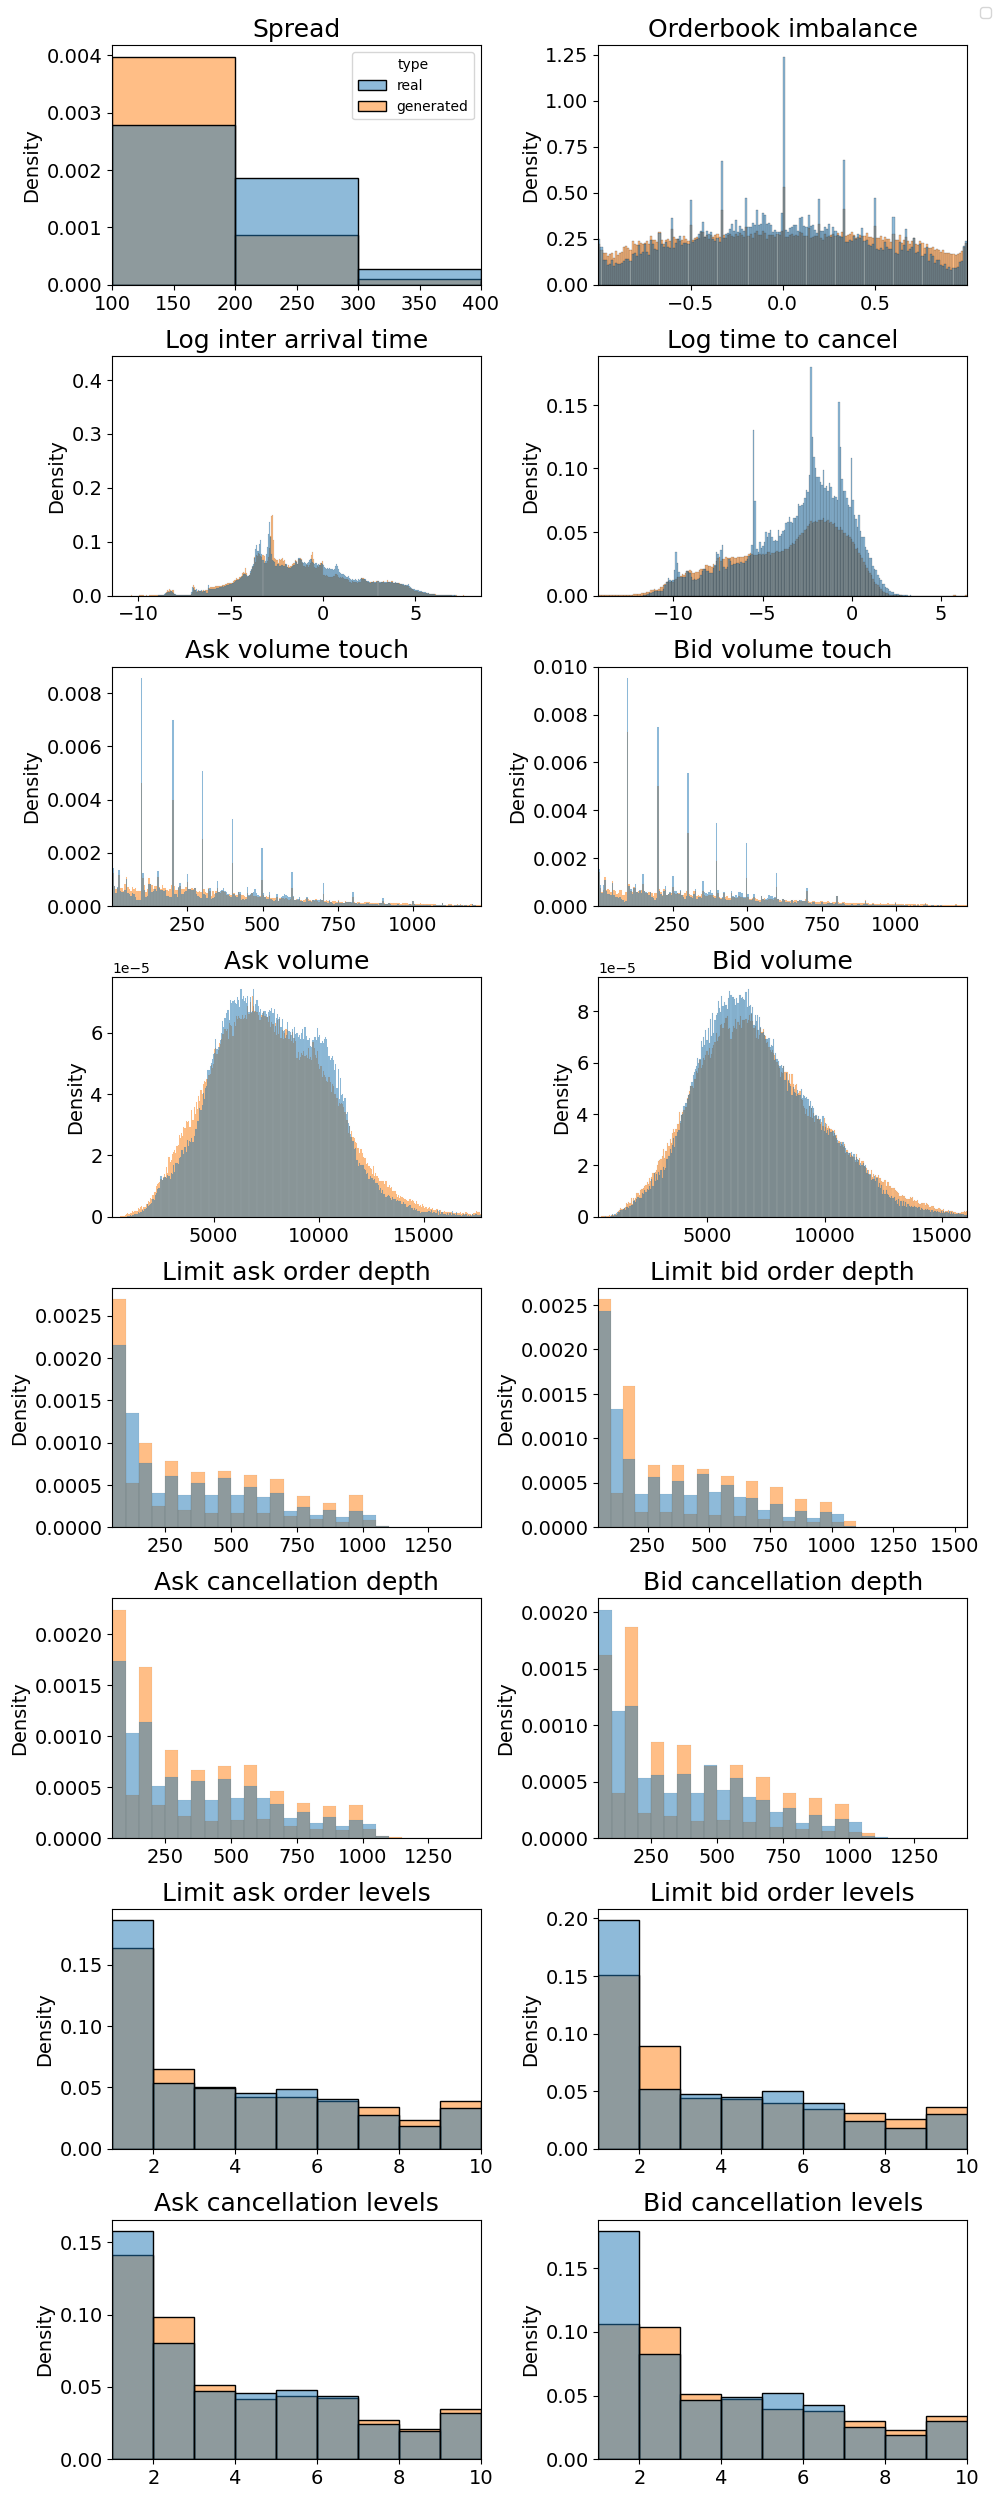

In [295]:
plotting.hist_subplots(
    plot_fns,
    figsize=(10, 25)
)

<Axes: xlabel='score', ylabel='Density'>

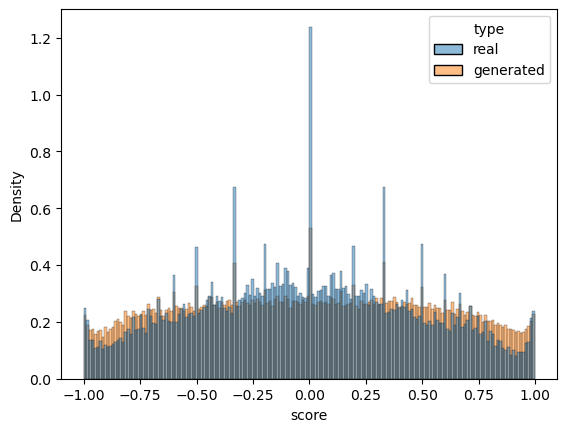

In [217]:
sns.histplot(
    score_dfs["orderbook_imbalance"],
    x="score",
    hue="type",
    stat="density",
    common_bins=True,
)

In [214]:
plot_fn = lambda title, ax: plotting.hist(
    score_dfs["orderbook_imbalance"].loc[score_dfs["orderbook_imbalance"].type == "real"].score.values,
    score_dfs["orderbook_imbalance"].loc[score_dfs["orderbook_imbalance"].type == "gen"].score.values,
    # bins=thresholds,
    title=title,
    xlabel=title,
    ax=ax,
)

plotting.py: n_Bins to use in histogram 4


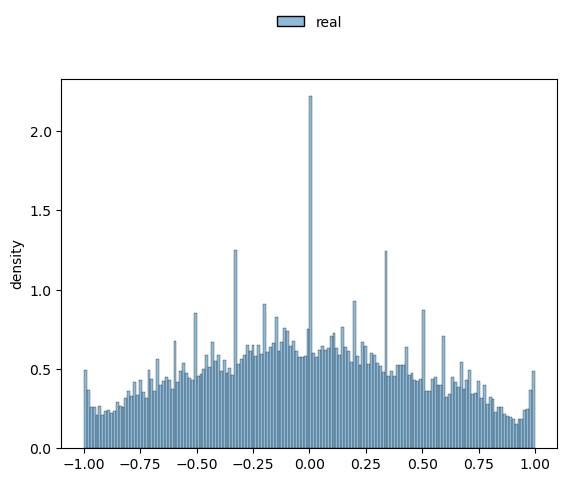

In [215]:
plot_fn('', plt.gca())

In [296]:
scores_coletta, scores_dfs_coletta = load_results(
    'data_saved/scores_uncond_GOOG_coletta_20241001_143123.pkl')

In [297]:
scores_coletta

{'spread': {'l1': (0.9468698412698413,
   array([0.94559365, 0.94832381]),
   array([0.94686984, 0.9468    , 0.94693333, 0.94695238, 0.94600635,
          0.94685079, 0.9471873 , 0.94633016, 0.94626667, 0.9472381 ,
          0.94758095, 0.94700317, 0.94630476, 0.9468381 , 0.94587302,
          0.94671111, 0.94650159, 0.94704762, 0.94695238, 0.94709206,
          0.94660317, 0.94711746, 0.94687619, 0.94697778, 0.94659048,
          0.94672381, 0.94726984, 0.94805714, 0.94703492, 0.94714286,
          0.94698413, 0.94537778, 0.94673016, 0.94764444, 0.94726984,
          0.9475746 , 0.94659048, 0.9471873 , 0.94600635, 0.94676825,
          0.94669841, 0.9464254 , 0.94685714, 0.94657778, 0.94646349,
          0.94715556, 0.94746667, 0.94748571, 0.9472127 , 0.94685714,
          0.94738413, 0.9460127 , 0.94674286, 0.94713651, 0.94618413,
          0.9467873 , 0.94670476, 0.94663492, 0.94650159, 0.94765714,
          0.94673651, 0.94654603, 0.94714286, 0.94684444, 0.94746032,
          0.947

## Evaluate divergence of distributions:

In [ ]:
# plot_fn = lambda title, ax: plotting.error_divergence_plot(
#     loss_horizons,
#     horizon_length,
#     title=title,
#     xlabel='Prediction Horizon [messages]',
#     ylabel='L1 score',
#     ax=ax,
# )

In [302]:
scores_, score_dfs_ = load_results(
    'data_saved/scores_div_100_GOOG_lobs5_20241002_005516.pkl')

In [303]:
scores_

{'spread': [(0.16471938775510203,
   array([0.16262085, 0.16653954]),
   array([0.16471939, 0.16587181, 0.16535714, 0.16474936, 0.16332207,
          0.16554145, 0.16524809, 0.16390561, 0.16533036, 0.16449617,
          0.16506505, 0.16601722, 0.16370408, 0.16514796, 0.16349107,
          0.16495344, 0.16462819, 0.16465625, 0.16506696, 0.16398214,
          0.16525319, 0.16528508, 0.16482653, 0.16481633, 0.16505166,
          0.16469962, 0.16456505, 0.16469069, 0.16558801, 0.16438839,
          0.16345217, 0.16582653, 0.16494707, 0.16515179, 0.16566645,
          0.16438457, 0.16499298, 0.16470663, 0.16346046, 0.16468495,
          0.16499745, 0.16536607, 0.16526849, 0.16476212, 0.16384566,
          0.16589094, 0.16426212, 0.16319579, 0.16425893, 0.16428763,
          0.16265497, 0.16519707, 0.16565179, 0.16578444, 0.16330421,
          0.16624554, 0.16370153, 0.16519515, 0.16485077, 0.16467411,
          0.16428316, 0.16529783, 0.16531505, 0.16364668, 0.16506505,
          0.16519898

In [308]:
plot_fn = lambda title, ax: plotting.error_divergence_plot(
    scores_["spread"],
    100,
    title="",
    xlabel="Prediction Horizon [messages]",
    ylabel="L1 score",
    ax=ax,
)

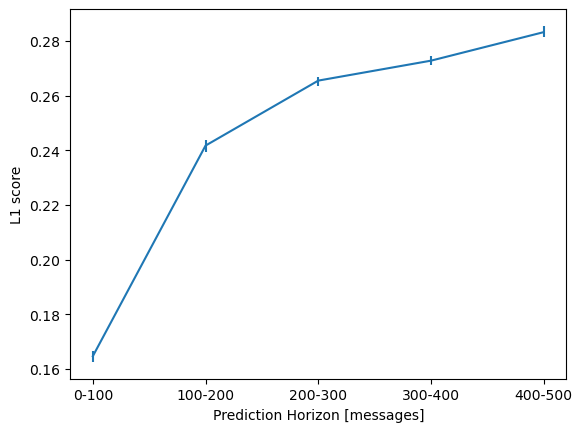

In [309]:
plot_fn('bla', plt.gca())

In [301]:
def get_div_plot_fn(scores, horizon_length=100):
    def _div_plot_fn(title, ax):
        plotting.error_divergence_plot(
            scores,
            horizon_length,
            title=title,
            xlabel="Prediction Horizon [messages]",
            ylabel="L1 score",
            ax=ax,
        )
    return _div_plot_fn

In [ ]:
plotting.hist_subplots(plot_fns_, (10, 25))
# plt.suptitle(f'L1 Divergence ({stock})', fontweight='bold')
# plt.tight_layout()
# plt.savefig(f'images/metric_divergence_{stock}.png', dpi=300, bbox_inches='tight')

In [756]:
scores_, score_dfs_, plot_fns_ = scoring.run_benchmark(
    loader, scoring_config_dict, metrics.l1_by_group,
    divergence_horizon=100,
    divergence=True)

# GOOG: 35 m

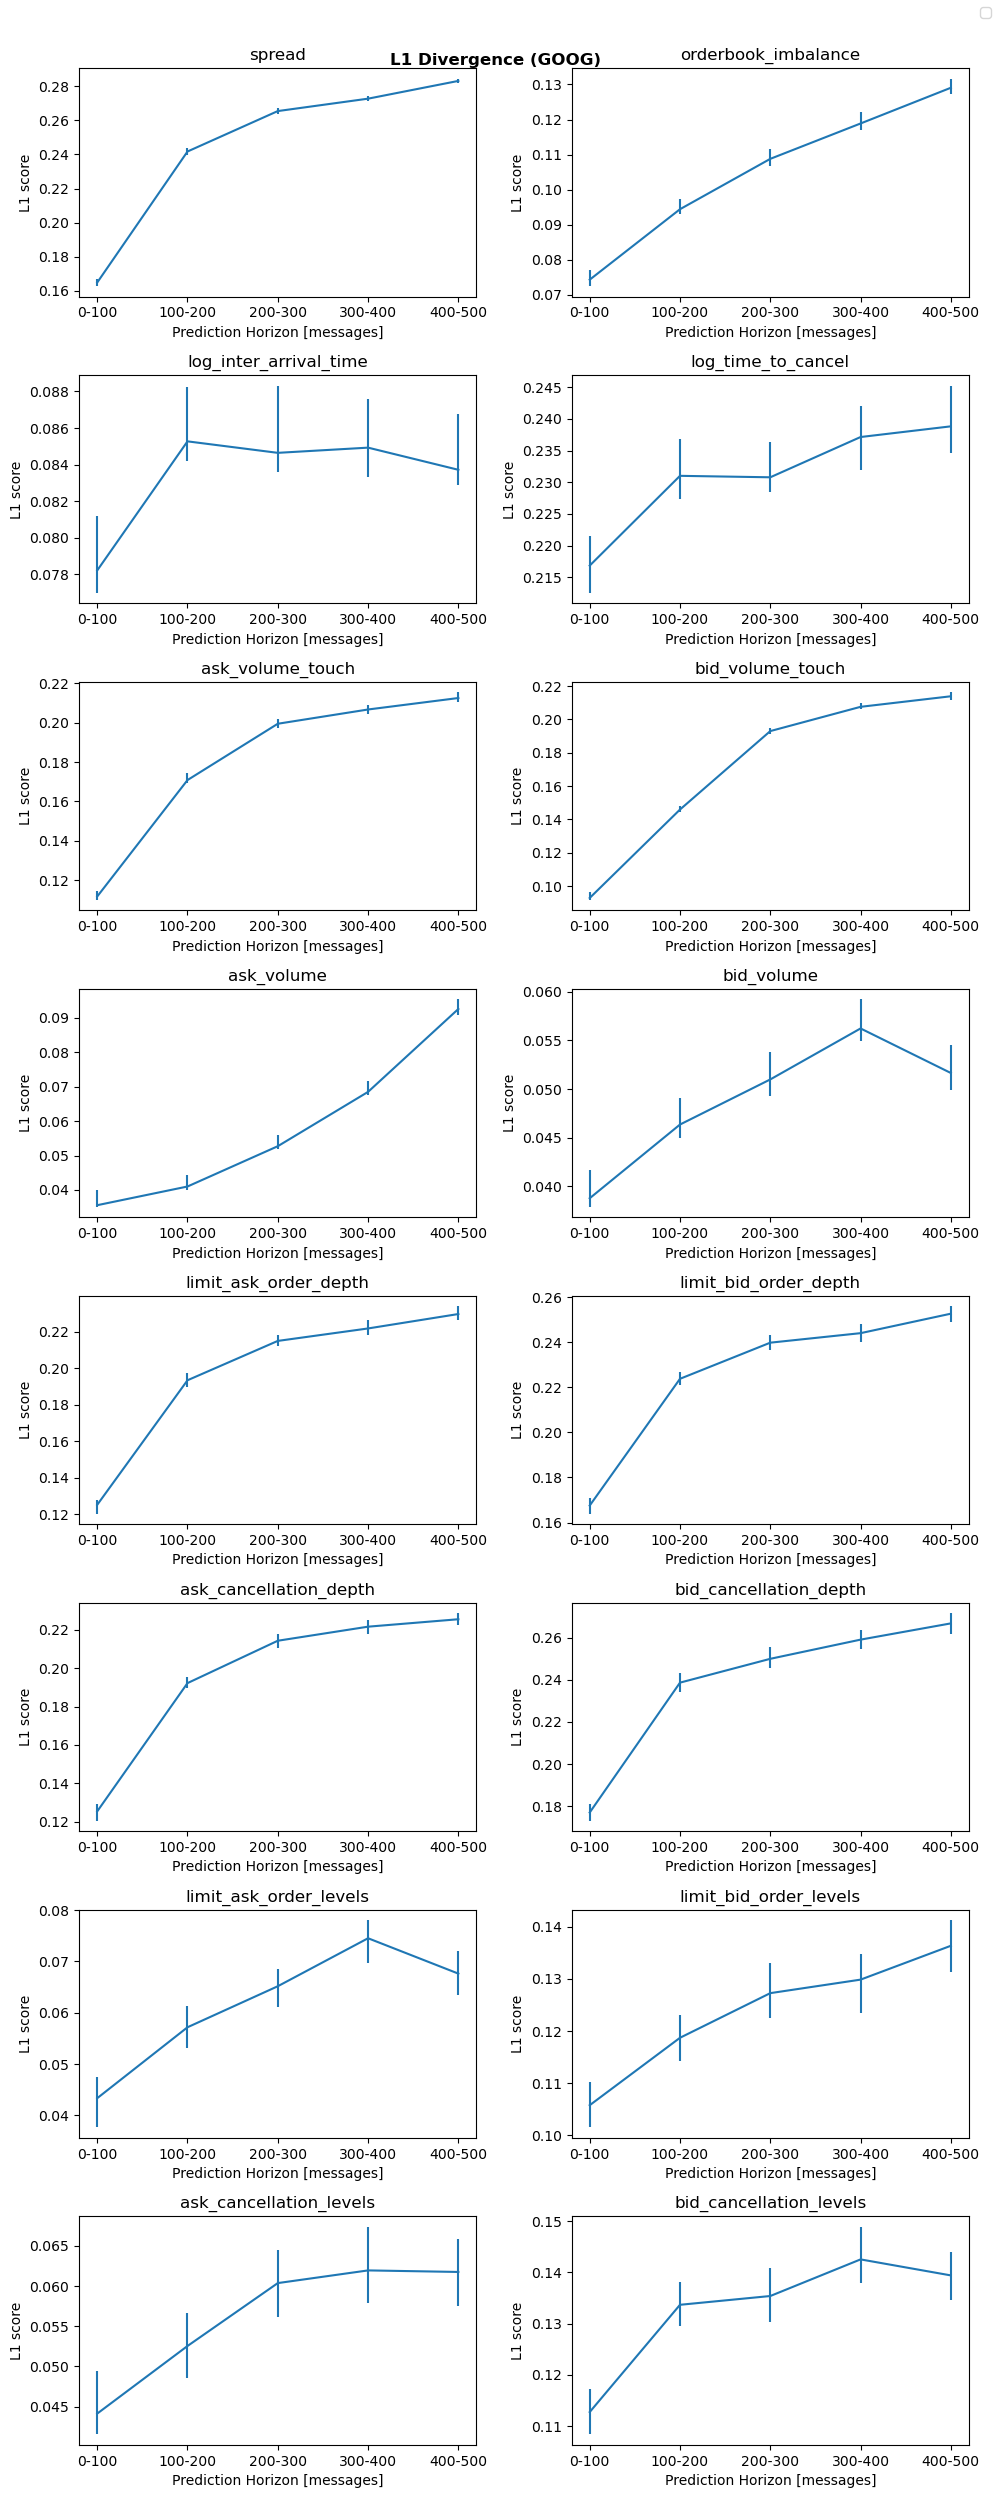

In [801]:
plotting.hist_subplots(plot_fns_, (10, 25))
plt.suptitle(f'L1 Divergence ({stock})', fontweight='bold')
plt.tight_layout()
plt.savefig(f'images/metric_divergence_{stock}.png', dpi=300, bbox_inches='tight')

In [ ]:
# next TODOs:
# plotting
# 3D book distances: L1, mahalonabis etc.

In [5]:
# score using mean per sequence
scoring_fn = lambda m, b: eval.spread(m, b).mean()
score_df, plot_fn = scoring.score_data(loader, scoring_fn, return_plot_fn=True)
display(score_df)

metrics.l1_by_group(score_df)

,score,group,type
0,182.0,3,real
1,286.0,3,real
2,185.0,3,real
3,108.0,1,real
4,122.0,1,real
...,...,...,...
315,131.0,2,generated
316,103.0,0,generated
317,100.0,0,generated
318,102.5,0,generated


0.09999999999999998

In [23]:
# test if the scoring thresholds works correctly

scores_real, scores_gen = partitioning.score_real_gen(loader, scoring_fn)

all_scores = np.concatenate((
    partitioning.flatten(scores_real),
    partitioning.flatten(scores_gen)
))
# all_scores = np.concatenate((
#     np.array(flatten(scores_real)).flatten(),
#     np.array(flatten(scores_gen)).flatten()
# ))

quantiles = [0.25, 0.5, 0.75]
min_score, max_score = all_scores.min(), all_scores.max()
thresholds = np.concatenate([[min_score], np.quantile(all_scores, quantiles), [max_score]])

groups_real = np.searchsorted(thresholds, scores_real, side='right') - 1
groups_gen = [
    np.searchsorted(thresholds, sg_i, side='right') - 1
    for sg_i in scores_gen
]

In [33]:
group_counts = score_df.groupby(['type', 'group']).count()
group_counts = pd.merge(group_counts.loc['real'], group_counts.loc['generated'], on='group')
# group_counts /= group_counts.sum(axis=0)
(group_counts.score_x - group_counts.score_y).abs().mean()

16.0

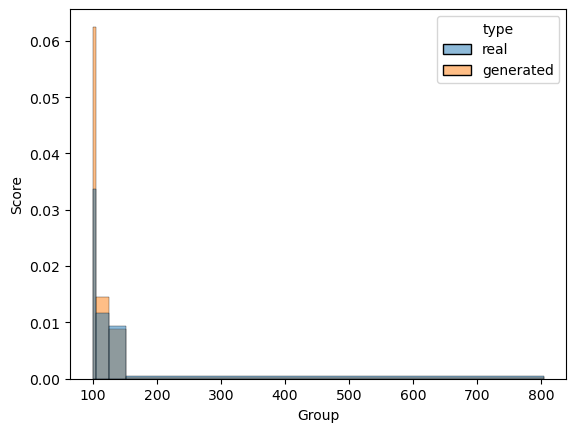

bins: [100.    105.    124.75  152.125 804.   ]


In [16]:
plot_fn()

In [142]:
# score using multiple values per sequence

scoring_fn = lambda m, b: eval.spread(m, b).values
score_df, plot_fn = scoring.score_data(loader, scoring_fn, discrete=True, return_plot_fn=True)
display(score_df)

metrics.l1_by_group(score_df)

,score,group,type
0,200,2,real
1,200,2,real
2,200,2,real
3,200,2,real
4,200,2,real
...,...,...,...
47995,200,2,generated
47996,200,2,generated
47997,200,2,generated
47998,200,2,generated


0.038955101086797866

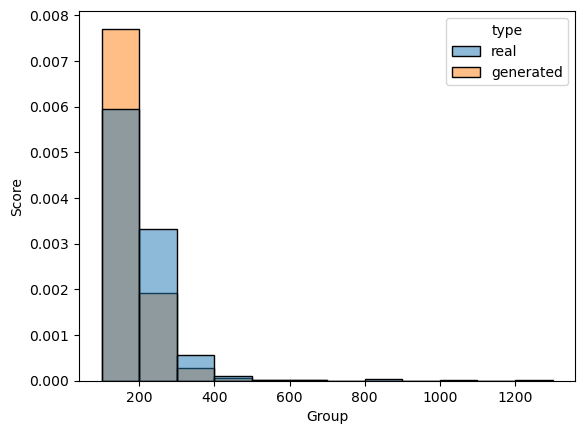

bins: [ 100  200  300  400  500  600  700  800  900 1000 1100 1200 1300]


In [143]:
plot_fn()

# more than 50% at 100 --> relatively high error because there are effectively only 3 groups

In [ ]:
scoring_fns = [
    lambda m, b: eval.spread(m, b).mean(),
    lambda m, b: eval.spread(m, b).mean(),

]

In [79]:
metrics.l1_by_group(score_df)

15.75

In [73]:
scores_real

[182.0,
 286.0,
 185.0,
 108.0,
 122.0,
 114.0,
 100.0,
 163.0,
 100.0,
 141.0,
 144.0,
 121.0,
 155.0,
 170.0,
 102.0,
 194.0,
 142.0,
 169.0,
 105.0,
 184.0,
 126.0,
 239.0,
 133.0,
 111.0,
 137.0,
 119.0,
 116.0,
 103.0,
 103.0,
 150.0,
 152.0,
 107.0,
 100.0,
 128.0,
 147.0,
 106.0,
 134.0,
 102.0,
 127.0,
 113.0,
 100.0,
 247.0,
 136.0,
 102.0,
 192.0,
 381.0,
 120.0,
 157.0,
 114.0,
 113.0,
 100.0,
 301.0,
 178.0,
 168.0,
 157.0,
 149.0,
 240.0,
 127.0,
 101.0,
 120.0,
 107.0,
 132.0,
 169.0,
 158.0,
 100.0,
 124.0,
 138.0,
 170.0,
 169.0,
 115.0,
 102.0,
 134.0,
 105.0,
 160.0,
 100.0,
 121.0,
 119.0,
 122.0,
 155.0,
 217.0,
 201.0,
 151.0,
 174.0,
 100.0,
 200.0,
 144.0,
 100.0,
 150.0,
 100.0,
 110.0,
 100.0,
 190.0,
 179.0,
 136.0,
 124.0,
 249.0,
 102.0,
 116.0,
 110.0,
 103.0,
 146.0,
 107.0,
 235.0,
 804.0,
 249.0,
 270.0,
 142.0,
 177.0,
 139.0,
 124.0,
 173.0,
 100.0,
 142.0,
 151.0,
 114.0,
 140.0,
 100.0,
 148.0,
 169.0,
 194.0,
 197.0,
 237.0,
 149.0,
 144.0,
 144.0,


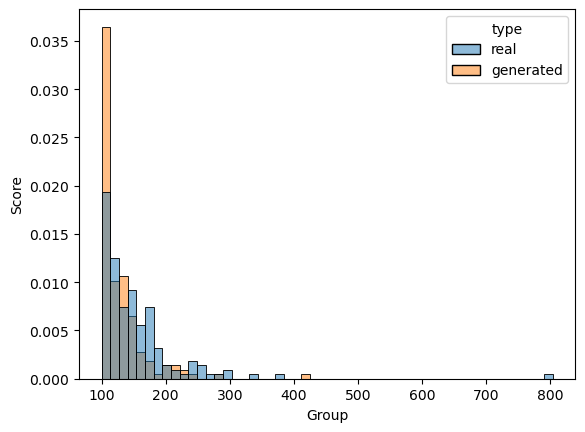

In [ ]:
plotting.hist(scores_real, scores_gen)

In [43]:
# print entire dataset
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(s.b_cond[0])

0      887200
1      887200
2      887200
3      887200
4      887200
5      887200
6      887200
7      887200
8      887200
9      887200
10     887200
11     887200
12     887200
13     887200
14     887200
15     887200
16     887200
17     887200
18     887200
19     887200
20     887200
21     887200
22     887200
23     887200
24     887200
25     887200
26     887200
27     887200
28     887200
29     887200
30     887200
31     887200
32     887200
33     887200
34     887200
35     887200
36     887200
37     887200
38     887200
39     887200
40     887200
41     887200
42     887200
43     887200
44     887200
45     887200
46     887200
47     887200
48     887200
49     887200
50     887200
51     887200
52     887200
53     887200
54     887200
55     887200
56     887200
57     887200
58     887200
59     887200
60     887300
61     887300
62     887300
63     887300
64     887300
65     887300
66     887300
67     887300
68     887300
69     887300
70     887300
71    

In [44]:
# print entire dataset
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(s.b_cond.loc[0])

0     887200
1        628
2     887000
3       1423
4     887300
5        970
6     886900
7       1174
8     887400
9        823
10    886800
11      2257
12    887500
13      2019
14    886700
15      1763
16    887600
17      1900
18    886600
19      1250
20    887700
21      1622
22    886500
23      2255
24    887800
25      1500
26    886400
27       451
28    887900
29       800
30    886300
31       911
32    888000
33      1250
34    886200
35      1565
36    888100
37       200
38    886100
39       547
Name: 0, dtype: int64
